# What's the Price of Wheat?

<img src="http://www.ictinternational.com/content/uploads/2015/02/wheat1.jpg" width=640 height=480/>

## Project Background and Motivation

We chose to create a predictor of the stock price of wheat because of the ever-pervasive fluctuation in food prices. Wheat is among one of the most fundamental agricultural commodities in the United States, so understanding and ultimately predicting the price of this commodity will allow us to understand an essential part of our economic ecosystem. Our team has diverse backgrounds in engineering and science, so we wanted to choose a topic that has profound global implications. One of the grand challenges identified by the leaders of the U.N. and world bank is the shortage of food in our ever growing population. We thought it would be interesting for us to be able to build predictive forecasting of the stock price of this key commodity.

In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# 1. Cleaning Data

#### We will be using precipitation, temperature, inflation, and the price of corn to predict the monthly price of wheat. 

Because we believe that the price of wheat is greatly influenced by the supply/production of wheat and that the production of wheat is affected by environmental factors such as precipitation and temperature as it is an agricultural product, we decided to use precipitation and temperature to predict the price of wheat. (We also wanted to use the production of wheat to predict the price of wheat but we were unable to find a dataset of the monthly production of wheat by each state; instead we found a dataset of the yearly production of wheat by each state. We will use that data to determine which states produce the most wheat so that we don't include states that produce very little to no wheat at all in our model.)

According to http://www.futuresknowledge.com/news-and-analysis/grains/the-top-factors-that-move-the-price-wheat/, wheat is also affected by inflation. It has been observed that the price of wheat tends to move with the rate of inflation, and so we decided to use inflation rate to predict the price of wheat.

It has also been observed that wheat and corn prices tend to move together, and so we decided to use corn price to predict the price of wheat as well.

#### We first need to clean our data before we can use it in our model.

### 1.1 Production of Wheat Data (Yearly)
Data obtained from: 

In [4]:
wheat_production=pd.read_csv("data/state_wheat_production_by_year.csv")
wheat_production.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2015,YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,WHEAT,"WHEAT - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,"14,960,000",NaN
1,SURVEY,2015,YEAR,NaN,STATE,ARIZONA,4,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,WHEAT,"WHEAT - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,"14,346,000",NaN
2,SURVEY,2015,YEAR,NaN,STATE,ARKANSAS,5,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,WHEAT,"WHEAT - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,"13,440,000",NaN
3,SURVEY,2015,YEAR,NaN,STATE,CALIFORNIA,6,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,WHEAT,"WHEAT - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,"16,680,000",NaN
4,SURVEY,2015,YEAR,NaN,STATE,COLORADO,8,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,WHEAT,"WHEAT - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,"79,635,000",NaN


There are a lot of columns that are unnecessary so let's remove those first.

In [5]:
del wheat_production['Program']
del wheat_production['Period']
del wheat_production['Geo Level']
del wheat_production['State ANSI']
del wheat_production['Ag District']
del wheat_production['Ag District Code']
del wheat_production['County']
del wheat_production['County ANSI']
del wheat_production['Zip Code']
del wheat_production['Region']
del wheat_production['watershed_code']
del wheat_production['Watershed']
del wheat_production['Commodity']
del wheat_production['Data Item']
del wheat_production['Domain']
del wheat_production['Domain Category']
del wheat_production['Week Ending']
wheat_production.head()

,Year,State,Value,CV (%)
0,2015,ALABAMA,"14,960,000",NaN
1,2015,ARIZONA,"14,346,000",NaN
2,2015,ARKANSAS,"13,440,000",NaN
3,2015,CALIFORNIA,"16,680,000",NaN
4,2015,COLORADO,"79,635,000",NaN


Let's change the state names to lowercase except for the first letter, and remove the commas from the production values and change the production values to floats.

In [6]:
wheat_production['State'] = wheat_production['State'].map(lambda x: x.title())
wheat_production['Value'] = wheat_production['Value'].map(lambda x: float(x.replace(',','')))
wheat_production.head()

,Year,State,Value,CV (%)
0,2015,Alabama,14960000,NaN
1,2015,Arizona,14346000,NaN
2,2015,Arkansas,13440000,NaN
3,2015,California,16680000,NaN
4,2015,Colorado,79635000,NaN


Store the cleaned wheat production data into csv file so we don't have to run this every time.

In [7]:
wheat_production.to_csv('cleaned_data/wheatproduction.csv')

### 1.2 Precipitation Data

Data from: http://www1.ncdc.noaa.gov/pub/data/normals/1981-2010/source-datasets/

Now, we want to consider precipitation. We reason that since all crops need water, low precipitation totals in a given month would raise the price of wheat. The dataset is loaded from a csv, which is taken from the National Centers for Environmental Information. This dataset is taken from data obtained by various weather stations within each state and compiled by each month of a year. The uncleaned data set is loaded from the data folder of this project.

In [8]:
dirtyprecdf=pd.read_csv("data/stationprec.csv")
dirtyprecdf.head(10)

,Station ID,Year,Jan,Feb,March,April,May,June,July,August,September,October,November,December
0,AQC00914000,1981,4279,3745,10762,6067,4096,3606,6203,5292,3092,6866,7163,7866
1,AQC00914000,1982,5039,9643,3211,2016,3355,2827,3199,9356,4150,6418,3965,1595
2,AQC00914000,1983,3351,2971,3044,2642,1644,1717,1020,1788,3433,6801,2531,7242
3,AQC00914000,1984,3368,3538,8187,2715,2916,3288,1246,3391,2932,6578,4787,9787
4,AQC00914000,1985,5202,3078,3279,8414,2884,4787,3447,3193,5296,5410,3950,1651
5,AQC00914000,1986,8573,4212,2799F,7095F,5012F,3135F,3878F,2989F,6368F,4740F,4312F,8310F
6,AQC00914000,1987,5146,7648,3954F,3573F,3118F,2788F,2043F,3498F,841,2669,2298,6208F
7,AQC00914000,1988,3336F,4798,4908,4400F,4297F,2817,3878,2548F,3792,4645,5969F,8915F
8,AQC00914000,1989,5523F,5806F,3273F,5388F,3672F,3079F,4166F,209,788,4982,6379,3731
9,AQC00914000,1990,4932,6857,3288,4518,1635,3598,2214,1541,2611,5439,4525,3530


There are a few things in the precipitation dataframe that we want to change. The numbers in each month need to be interpreted, since it is often in the form ####F. There are also some results with -9999M, which we want to get rid of, since those indicate missing data. We want to get rid of the letters and turn the number into an understandable inch unit. According to the readme from our source, each number is the number of 1/100ths of an inch (e.g. 1486 = 14.86 inches)

In [9]:
precdf=dirtyprecdf
# remove the -9999M rows, the F, and turn numbers to inch values
for col in precdf:
    if (col!="Station ID" and col!= "Year"):
        precdf= precdf[precdf[col] != '-9999M']
        precdf[col]=precdf[col].map(lambda x: x.rstrip("F"))
        precdf[col]=precdf[col].map(lambda x: float(x)/100.00)
precdf.head()

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Station ID,Year,Jan,Feb,March,April,May,June,July,August,September,October,November,December
0,AQC00914000,1981,42.79,37.45,107.62,60.67,40.96,36.06,62.03,52.92,30.92,68.66,71.63,78.66
1,AQC00914000,1982,50.39,96.43,32.11,20.16,33.55,28.27,31.99,93.56,41.50,64.18,39.65,15.95
2,AQC00914000,1983,33.51,29.71,30.44,26.42,16.44,17.17,10.20,17.88,34.33,68.01,25.31,72.42
3,AQC00914000,1984,33.68,35.38,81.87,27.15,29.16,32.88,12.46,33.91,29.32,65.78,47.87,97.87
4,AQC00914000,1985,52.02,30.78,32.79,84.14,28.84,47.87,34.47,31.93,52.96,54.10,39.50,16.51


Station IDs aren't really helpful to us, and instead we want to convert this to the states that each station is in. This is given to use by an index of stations from the same data source in the same folder as the precipitation dataset.

In [10]:
statiddf=pd.read_csv("data/statid.csv")
statiddf=statiddf[['Station ID', 'State']]
statid={}
for index, row in statiddf.iterrows():
    statid[row['Station ID']]=row['State']
# hard code some values that aren't in the station id list, but appear in precdf
statid['USC00085612']='FL'

In [11]:
state = []
for id in precdf['Station ID']:
    state.append(statid[id])
precdf['state'] = state
precdf=precdf.drop('Station ID', axis=1)
precdf.head()

,Year,Jan,Feb,March,April,May,June,July,August,September,October,November,December,state
0,1981,42.79,37.45,107.62,60.67,40.96,36.06,62.03,52.92,30.92,68.66,71.63,78.66,AS
1,1982,50.39,96.43,32.11,20.16,33.55,28.27,31.99,93.56,41.50,64.18,39.65,15.95,AS
2,1983,33.51,29.71,30.44,26.42,16.44,17.17,10.20,17.88,34.33,68.01,25.31,72.42,AS
3,1984,33.68,35.38,81.87,27.15,29.16,32.88,12.46,33.91,29.32,65.78,47.87,97.87,AS
4,1985,52.02,30.78,32.79,84.14,28.84,47.87,34.47,31.93,52.96,54.10,39.50,16.51,AS


Now let's modify the column names. We want to standardize the name of months to the abbreviated month names.

In [12]:
precdf.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
                  'Sep', 'Oct', 'Nov', 'Dec', 'State']
precdf.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,State
0,1981,42.79,37.45,107.62,60.67,40.96,36.06,62.03,52.92,30.92,68.66,71.63,78.66,AS
1,1982,50.39,96.43,32.11,20.16,33.55,28.27,31.99,93.56,41.50,64.18,39.65,15.95,AS
2,1983,33.51,29.71,30.44,26.42,16.44,17.17,10.20,17.88,34.33,68.01,25.31,72.42,AS
3,1984,33.68,35.38,81.87,27.15,29.16,32.88,12.46,33.91,29.32,65.78,47.87,97.87,AS
4,1985,52.02,30.78,32.79,84.14,28.84,47.87,34.47,31.93,52.96,54.10,39.50,16.51,AS


Now group the rows by state and year, and find the average precipitation recorded of all the weather stations in a single state. We will then be left with average rainfall per month for each state in a given year.

In [13]:
prec_grouped = precdf.groupby(['State','Year']).mean().reset_index()
prec_grouped.head(10)

,State,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,AK,1981,15.683362,8.257069,8.708879,3.853276,4.915259,6.550172,10.535862,15.486552,12.651207,12.820948,12.226121,7.486121
1,AK,1982,5.100342,3.618462,5.281624,5.847863,6.187179,5.819829,7.964359,6.752137,15.152222,11.733419,9.297863,9.896068
2,AK,1983,7.984655,6.574655,2.432241,7.119828,6.262931,4.087155,6.538879,13.819310,10.171466,13.382414,8.525172,3.358017
3,AK,1984,12.432069,8.805259,6.767759,5.168362,4.187759,6.101121,8.322500,10.346638,8.663448,9.372586,7.268966,10.093190
4,AK,1985,15.284348,7.119652,8.681217,5.548087,5.936609,7.537130,5.375565,10.198435,13.984087,9.077913,4.656261,15.266783
5,AK,1986,12.364872,6.162650,6.593077,4.190427,4.491368,4.831368,7.465470,11.689744,8.029231,18.506838,10.268120,15.018718
6,AK,1987,13.020000,7.321282,5.140513,5.975641,6.503419,10.063504,6.694017,5.087863,17.302222,17.963675,13.330855,10.894957
7,AK,1988,7.215470,9.894017,9.811880,7.323504,6.320000,6.074530,6.445641,11.865556,10.154017,14.196752,10.109829,13.272650
8,AK,1989,8.603621,2.369569,2.484310,4.185862,7.217845,6.950517,6.059138,10.700517,14.211724,15.089397,10.749397,15.118621
9,AK,1990,9.548205,7.374872,7.928034,3.385556,3.875385,5.460855,7.563504,10.194103,18.809231,10.304786,6.216667,11.274872


Now, some of the datasets that we will use do not have all of these years. In order to work with the most features available to us for our early data analysis and later on, our model, we only use the years where all of our data can be found. In this case, some of our data only starts in 1995 and some of our data ends in 2011. For the sake of uniformity, we limit all of our datasets to the years between these dates.

In [14]:
prec_grouped=prec_grouped[(prec_grouped['Year'] > 1994) & (prec_grouped['Year'] < 2011)].set_index(['State']).reset_index()

Store the cleaned precipitation data into csv file so we don't have to run this every time.

In [15]:
prec_grouped.to_csv('cleaned_data/precdf.csv')

### 1.3 Temperature Data

Now that we have cleaned the data for the precipitation, we follow a similar procedure for temperature. Since the temperature data is from the same source, we will follow almost exactly the same procedure.

In [16]:
dirtytempdf=pd.read_csv("data/stationtemp.csv")
dirtytempdf.head()

//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,Station,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,AQW00061705,1981,2750,2700,2690,2670,2685,2605,2600,2610,2685,2645,2700,2710
1,AQW00061705,1982,2765,2675,2785,2750,2700,2675,2585,2600,2610,2695,2665,2715
2,AQW00061705,1983,2775,2850,2755,2720,2715,2635,2580,2560,2665,2630,2680,2735
3,AQW00061705,1984,2700,2740,2725,2745,2750,2685,2600,2640,2630,2630,2710,2670
4,AQW00061705,1985,2675,2745,2780,2700,2685,2660,2630,2650,2640,2700,2685,2750


The only difference here is that there are no F's to worry about.

In [17]:
# remove the -9999M rows, and convert to degrees celsius
for col in dirtytempdf:
    if (col!="Station" and col!= "Year"):
        dirtytempdf= dirtytempdf[dirtytempdf[col] != '-9999M']
        dirtytempdf[col]=dirtytempdf[col].map(lambda x: float(x)/100.00)

In [18]:
state = []
for id in dirtytempdf['Station']:
    state.append(statid[id])
dirtytempdf['State'] = state
dirtytempdf=dirtytempdf.drop('Station', axis=1)
dirtytempdf.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,State
0,1981,27.50,27.00,26.90,26.70,26.85,26.05,26.00,26.1,26.85,26.45,27.00,27.10,AS
1,1982,27.65,26.75,27.85,27.50,27.00,26.75,25.85,26.0,26.10,26.95,26.65,27.15,AS
2,1983,27.75,28.50,27.55,27.20,27.15,26.35,25.80,25.6,26.65,26.30,26.80,27.35,AS
3,1984,27.00,27.40,27.25,27.45,27.50,26.85,26.00,26.4,26.30,26.30,27.10,26.70,AS
4,1985,26.75,27.45,27.80,27.00,26.85,26.60,26.30,26.5,26.40,27.00,26.85,27.50,AS


In [19]:
tdf=dirtytempdf.groupby(['State','Year']).mean().reset_index()
tdf.head(10)

,State,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,AK,1981,-7.316923,-10.849936,-2.146795,-0.466090,7.246795,11.301154,12.566090,11.463397,6.910577,-0.061474,-7.999615,-11.240769
1,AK,1982,-10.096667,-12.740577,-6.355897,-3.707115,4.874872,10.444679,13.082628,11.590128,7.221410,-3.105769,-10.229295,-7.180000
2,AK,1983,-10.949359,-9.052115,-6.856731,-1.559167,6.256795,11.532115,13.462115,11.002885,6.548077,-0.134551,-6.825641,-8.156731
3,AK,1984,-9.910449,-10.662051,-4.902692,-0.588718,6.524423,11.626667,13.034487,11.729359,7.952244,1.275385,-7.563333,-10.658910
4,AK,1985,-7.611731,-10.805769,-4.969167,-1.978077,6.095833,10.585897,13.630897,11.520577,6.658910,-2.034872,-10.239231,-7.453141
5,AK,1986,-14.249103,-9.054231,-8.436218,-1.005705,6.271795,11.427564,13.800705,11.938141,8.632692,0.615449,-9.357885,-6.661538
6,AK,1987,-11.177949,-13.390192,-5.334359,0.910128,7.198205,11.196282,13.571667,12.937628,7.433910,0.373910,-10.005577,-11.839038
7,AK,1988,-11.770385,-9.302564,-6.103590,0.414936,6.838333,11.586667,13.255641,11.353526,7.934808,-1.215641,-8.665321,-9.423782
8,AK,1989,-13.934968,-10.375097,-6.601097,0.337226,5.417097,11.458194,14.438710,12.680194,5.787161,-1.266968,-8.512065,-10.032129
9,AK,1990,-13.171731,-12.929231,-4.614231,2.455962,8.081154,12.093910,14.583205,12.959615,7.465449,0.566731,-9.072564,-9.837692


We limit by years again, just like in the precipitation dataset.

In [20]:
tdf=tdf[(tdf['Year'] > 1994) & (tdf['Year'] < 2011)].set_index(['State']).reset_index()
tdf.columns=['State','Year','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
tdf.head()

,State,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,AK,1995,-12.445260,-8.367532,-6.563247,2.549675,7.728182,11.788766,13.526364,11.594935,8.864935,0.430714,-7.723701,-11.932468
1,AK,1996,-16.260000,-13.498442,-6.184740,0.217078,6.951558,11.842403,13.753377,11.788052,7.029416,-2.241494,-9.112078,-13.413636
2,AK,1997,-13.658117,-5.749416,-5.873701,0.772532,6.700390,12.387532,13.926818,12.079545,8.146623,-1.473896,-4.614805,-8.935065
3,AK,1998,-9.501494,-7.298896,-4.462338,1.345455,5.668506,11.687597,13.703896,11.593896,7.624156,-0.392922,-7.814026,-13.244805
4,AK,1999,-11.512987,-12.314610,-7.826104,-1.812532,6.167078,11.702922,13.491558,12.104545,8.021429,1.039286,-4.866364,-9.715584


Store the cleaned temperature data into a csv file.

In [21]:
tdf.to_csv('cleaned_data/tempdf.csv')

### 1.4 Corn Price Data
Data obtained from: http://www.indexmundi.com/commodities/?commodity=corn&months=300.

In [22]:
cornprice_df=pd.read_csv("data/cornPrice_perMonth_1990_2015.csv")
cornprice_df.head()

,Maize (corn) - Monthly Price,Unnamed: 1,Unnamed: 2
0,Month,Price,Change
1,Nov-90,100,-
2,Dec-90,102.36,2.36%
3,Jan-91,105.51,3.08%
4,Feb-91,106.29,0.74%


We will split the first column into two separate columns for month and year.

In [23]:
# change column names
cornprice_df.columns = ['month-year', 'price', 'change']
# remove first row
cornprice_df = cornprice_df[~cornprice_df['month-year'].isin(['Month'])]
# add columns for month and year
month = []
year = []
for row in cornprice_df['month-year']:
    suffix_year = row.split('-')
    month.append(suffix_year[0])
    if suffix_year[1][0] == '9':
        year.append('19'+suffix_year[1])
    else:
        year.append('20'+suffix_year[1])
cornprice_df['month'] = month
cornprice_df['year'] = year
# remove month-year column 
cornprice_df = cornprice_df.drop('month-year', axis=1)
cornprice_df.head()

,price,change,month,year
1,100,-,Nov,1990
2,102.36,2.36%,Dec,1990
3,105.51,3.08%,Jan,1991
4,106.29,0.74%,Feb,1991
5,109.05,2.60%,Mar,1991


Now we want to index the corn dataframe by year and month, which will make it slightly more uniform with our other datasets. We also want to clean up the percent change of corn prices from the previous month so that it is a float instead of a string. Again, since some of our data sources don't start keeping data until 1995, and some stop recording data after 2011, we will only look at the data between those years.

In [24]:
cornprice_df=cornprice_df.set_index(['year','month']).reset_index()
cornprice_df['year']=cornprice_df['year'].map(lambda x: int(x))
cornprice_df=cornprice_df[(cornprice_df['year'] > 1994) & (cornprice_df['year'] < 2011)].set_index(['year']).reset_index()
cornprice_df.columns=['Year','Month','Corn_Price','CP_%_Change']
cornprice_df['CP_%_Change']=cornprice_df['CP_%_Change'].map(lambda x: x.rstrip("%"))
cornprice_df['CP_%_Change']=cornprice_df['CP_%_Change'].map(lambda x: float(x))

In [25]:
cornprice_df.head()

,Year,Month,Corn_Price,CP_%_Change
0,1995,Jan,106.9,4.23
1,1995,Feb,106.98,0.07
2,1995,Mar,109.63,2.48
3,1995,Apr,109.64,0.01
4,1995,May,111.93,2.09


Store the cleaned corn price data into a csv file.

In [26]:
cornprice_df.to_csv('cleaned_data/cornpricedf.csv')

### 1.5 Sorghum Data
Data obtained from: 

Along with corn, we also consider sorghum. We included sorghum, because like corn, it is a similar type of crop to wheat. It grows under similar conditions, and they can be considered substitute goods. We clean sorghum data much like we did for corn.

In [27]:
sorghumprice_df=pd.read_csv("data/sorghumprice.csv")

#rename column names for easy calling (retrieval)
sorghumprice_df.columns = ['month-year', 'price', 'change']
sorghumprice_df = sorghumprice_df[~sorghumprice_df['month-year'].isin(['Month'])]

# Split the Month and the Year
month = []
year = []
for row in sorghumprice_df['month-year']:
    suffix_year = row.split('-')
    month.append(suffix_year[0])
    if suffix_year[1][0] == '9':
        year.append('19'+suffix_year[1])
    else:
        year.append('20'+suffix_year[1])
sorghumprice_df['Month'] = month
sorghumprice_df['Year'] = year

# remove month-year column 
sorghumprice_df.drop('month-year', axis=1)

# rearrange columns 
sorghumprice_df = sorghumprice_df[['Month', 'Year', 'price','change']]

# remove extranneous numbers of first row
sorghumprice_df.drop(sorghumprice_df.columns[0], axis=1)
sorghumprice_df.columns = ['Month', 'Year', 'Price','change']
sorghumprice_df.head()

,Month,Year,Price,change
1,Nov,1990,98.16,-
2,Dec,1990,100.97,2.86%
3,Jan,1991,105.07,4.06%
4,Feb,1991,106.37,1.24%
5,Mar,1991,109.9,3.32%


In [28]:
sorghumprice_df=sorghumprice_df.set_index(['Year','Month']).reset_index()
sorghumprice_df['Year']=sorghumprice_df['Year'].map(lambda x: int(x))
sorghumprice_df=sorghumprice_df[(sorghumprice_df['Year'] > 1994) & (sorghumprice_df['Year'] < 2011)].set_index(['Year']).reset_index()
sorghumprice_df.columns=['Year','Month','Sorghum_Price','SP_%_Change']
sorghumprice_df['SP_%_Change']=sorghumprice_df['SP_%_Change'].map(lambda x: float(x.rstrip("%")))
sorghumprice_df.head()

,Year,Month,Sorghum_Price,SP_%_Change
0,1995,Jan,101.74,1.11
1,1995,Feb,102.07,0.32
2,1995,Mar,102.74,0.66
3,1995,Apr,103.29,0.54
4,1995,May,108.06,4.62


We again store the cleaned data into a csv for easy retrieval later on if needed.

In [29]:
sorghumprice_df.to_csv('cleaned_data/sorghumprice_df.csv')

### 1.6 Inflation Data
Data obtained from: http://inflationdata.com/Inflation/Inflation_Rate/Monthly_Inflation.aspx

In [30]:
inflation_df = pd.read_csv("data/inflationdata.csv")
inflation_df.head()

,Unnamed: 0,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1990,1.03%,0.47%,0.55%,0.16%,0.23%,0.54%,0.38%,0.92%,0.84%,0.60%,0.22%,0.00%
1,1991,0.60%,0.15%,0.15%,0.15%,0.30%,0.29%,0.15%,0.29%,0.44%,0.15%,0.29%,0.07%
2,1992,0.15%,0.36%,0.51%,0.14%,0.14%,0.36%,0.21%,0.28%,0.28%,0.35%,0.14%,-0.07%
3,1993,0.49%,0.35%,0.35%,0.28%,0.14%,0.14%,0.00%,0.28%,0.21%,0.41%,0.07%,0.00%
4,1994,0.27%,0.34%,0.34%,0.14%,0.07%,0.34%,0.27%,0.40%,0.27%,0.07%,0.13%,0.00%


We will update the column names and remove the '%' from each cell.

In [31]:
# rename column names for easy calling (retrieval)
inflation_df.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Iterate through the data and remove the % from the inflation rates to only have the values of percentages in the table
for col in inflation_df:
        if (col!="Year"):
            inflation_df[col]=inflation_df[col].map(lambda x: x.replace("%", ""))
inflation_df=inflation_df[(inflation_df['Year'] > 1994) & (inflation_df['Year'] < 2011)].set_index(['Year']).reset_index()
inflation_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1995,0.40,0.40,0.33,0.33,0.20,0.20,0.00,0.26,0.20,0.33,-0.07,-0.07
1,1996,0.59,0.32,0.52,0.39,0.19,0.06,0.19,0.19,0.32,0.32,0.19,0.00
2,1997,0.32,0.31,0.25,0.12,-0.06,0.12,0.12,0.19,0.25,0.25,-0.06,-0.12
3,1998,0.19,0.19,0.19,0.18,0.18,0.12,0.12,0.12,0.12,0.24,0.00,-0.06
4,1999,0.24,0.12,0.30,0.73,0.00,0.00,0.30,0.24,0.48,0.18,0.06,0.00


Store the cleaned inflation data into a csv file

In [32]:
inflation_df.to_csv('cleaned_data/inflationdf.csv')

### 1.7 Wheat Price Data
Data obtained from: http://www.indexmundi.com/commodities/?commodity=wheat&months=300.

In [33]:
price_df=pd.read_csv("data/price_of_wheat.csv")
price_df.head()

,Wheat - Monthly Price,Unnamed: 1,Unnamed: 2
0,Month,Price,Change
1,Nov-90,112.8,-
2,Dec-90,113.17,0.33%
3,Jan-91,111.33,-1.63%
4,Feb-91,113.91,2.32%


In [34]:
# change column names
price_df.columns = ['month-year', 'price', 'change']
# remove first row
price_df = price_df[~price_df['month-year'].isin(['Month'])]
# add columns for month and year
month = []
year = []
for row in price_df['month-year']:
    time = row.split('-')
    month.append(time[0])
    if time[1][0] == '9':
        year.append('19'+time[1])
    else:
        year.append('20'+time[1])
price_df['month'] = month
price_df['year'] = year
# remove month-year column
price_df = price_df.drop('month-year', axis=1)
price_df.head()

,price,change,month,year
1,112.8,-,Nov,1990
2,113.17,0.33%,Dec,1990
3,111.33,-1.63%,Jan,1991
4,113.91,2.32%,Feb,1991
5,119.42,4.84%,Mar,1991


We continue to clean this data just like how we cleaned corn price and sorghum data. 

In [35]:
price_df=price_df.set_index(['year','month']).reset_index()
price_df['year']=price_df['year'].map(lambda x: int(x))
price_df=price_df[(price_df['year'] > 1994) & (price_df['year'] < 2011)].set_index(['year']).reset_index()
price_df.columns=['Year','Month','Wheat_Price','WP_%_Change']
price_df['WP_%_Change']=price_df['WP_%_Change'].map(lambda x: float(x.rstrip("%")))
price_df.head()

,Year,Month,Wheat_Price,WP_%_Change
0,1995,Jan,156.21,-5.11
1,1995,Feb,154.42,-1.15
2,1995,Mar,150.39,-2.61
3,1995,Apr,148.98,-0.94
4,1995,May,158.61,6.46


Store the cleaned wheat price data into a csv file.

In [36]:
price_df.to_csv('cleaned_data/wheatprice_df.csv')

##1.8 Palmer Drought Severity Index Data
Data from: http://www1.ncdc.noaa.gov/pub/data/cirs/climdiv/climdiv-pdsidv-v1.0.0-20151104

The final feature we consider is the Palmer Drought Severity Data. This quantifies how bad a drought is, which is a major factor in crop production. We first start off by downloading the dataset.

In [37]:
pdsi_df=pd.read_csv('data/pdsi.csv')
pdsi_df.head()

,ID,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,101051895,0.49,-0.86,-0.50,-1.08,-1.28,0.10,0.25,0.41,-0.13,-0.17,-0.90,-0.74
1,101051896,-1.34,0.56,0.60,-0.35,-0.99,-0.69,-0.93,-1.60,-1.79,-2.06,-1.54,-2.29
2,101051897,-2.39,-2.59,1.93,1.79,-0.33,-0.93,-1.34,-1.33,-2.41,-2.79,-3.24,-2.28
3,101051898,-1.72,-2.51,-2.81,-2.49,-3.12,-3.49,-3.13,-2.95,-3.03,-2.53,-2.47,-2.85
4,101051899,-2.45,-1.80,-0.68,-1.08,-2.09,-2.74,-2.35,-2.51,-3.18,-3.42,-3.38,-2.63


Based on documentation from the source website, the ID should be 10 digits. It appears that during the csv process, leading 0's in the ID are deleted, so we will go through the process of adding them. 

In [38]:
pdsi_df['ID']=pdsi_df['ID'].map(lambda x: '0'+str(x) if len(str(x))==9 else x)
pdsi_df.head()

,ID,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0101051895,0.49,-0.86,-0.50,-1.08,-1.28,0.10,0.25,0.41,-0.13,-0.17,-0.90,-0.74
1,0101051896,-1.34,0.56,0.60,-0.35,-0.99,-0.69,-0.93,-1.60,-1.79,-2.06,-1.54,-2.29
2,0101051897,-2.39,-2.59,1.93,1.79,-0.33,-0.93,-1.34,-1.33,-2.41,-2.79,-3.24,-2.28
3,0101051898,-1.72,-2.51,-2.81,-2.49,-3.12,-3.49,-3.13,-2.95,-3.03,-2.53,-2.47,-2.85
4,0101051899,-2.45,-1.80,-0.68,-1.08,-2.09,-2.74,-2.35,-2.51,-3.18,-3.42,-3.38,-2.63


The first two numbers of the ID represent the state the data is taken in, which is what we want. The last four numbers of the ID tell us the year the data was taken in. We want to get both of these values into our dataframe, and we can ignore the other digits. We first import the list of digits that correspond to each state. Then we create lists of year and state, then add these two lsits as columns to our dataframe.

In [39]:
 state_digits={'01': 'Alabama', '02':'Arizona', '03':'Arkansas','04':'California','05':'Colorado','06':'Connecticut',
               '07':'Delaware','08':'Florida','09':'Georgia','10':'Idaho','11':'Illinois','12':'Indiana','13':'Iowa',
               '14':'Kansas','15':'Kentucky','16':'Louisiana','17':'Maine','18':'Maryland','19':'Massachusetts',
               '20':'Michigan','21':'Minnesota','22':'Mississippi','23':'Missouri','24':'Montana','25':'Nebraska',
               '26':'Nevada','27':'New Hampshire','28':'New Jersey', '29':'New Mexico','30':'New York','31':'North Carolina',
               '32':'North Dakota','33':'Ohio','34':'Oklahoma','35':'Oregon','36':'Pennsylvania','37':'Rhode Island',
               '38':'South Carolina','39':'South Dakota','40':'Tennessee','41':'Texas','42':'Utah','43':'Vermont',
               '44':'Virginia','45':'Washington','46':'West Virginia','47':'Wisconsin','48':'Wyoming'}

In [40]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}
rev_states={v: k for k, v in states_abbrev.items()}

In [41]:
year=[]
states=[]
pdsi_df['ID']=pdsi_df['ID'].map(lambda x: str(x))
for id in pdsi_df['ID']:
    if int(id[:2])>48:
        states.append('ZZ')
        year.append(2000)
    else:
        states.append(state_digits[id[:2]])
        year.append(int(id[-4:]))
pdsi_df['State']=states
pdsi_df['Year']=year
pdsi_df=pdsi_df[pdsi_df['State']!='ZZ']
pdsi_df['State']=pdsi_df['State'].map(lambda x: rev_states[x])
del pdsi_df['ID']
pdsi_df=pdsi_df[(pdsi_df['Year'] > 1994) & (pdsi_df['Year'] < 2011)].set_index(['Year']).reset_index()
pdsi_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,State
0,1995,-0.49,-0.54,-0.97,-0.67,-0.84,0.11,0.04,0.02,0.12,1.10,1.44,1.05,AL
1,1996,1.33,-0.70,-0.35,-0.01,-0.80,-1.00,0.64,0.77,1.64,1.65,1.91,1.99,AL
2,1997,2.03,1.69,1.32,1.13,1.92,4.13,3.20,3.23,3.33,4.02,3.34,2.73,AL
3,1998,2.91,2.91,-0.27,0.35,-0.39,-0.75,-0.47,-0.47,-1.31,-1.62,-1.98,0.43,AL
4,1999,1.49,-0.61,-0.47,-0.82,0.15,1.15,-0.20,-1.19,-1.89,-2.27,-2.09,-2.43,AL


We then want to organize it be state and year like our other datasets.

In [42]:
pdsi_station_df=pdsi_df.groupby(['State','Year']).mean().reset_index()
pdsi_station_df.head()

,State,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,AL,1995,-0.43250,-0.29000,-0.57125,-0.4975,-0.75375,-0.71625,-1.25000,-1.30875,-0.86750,1.98375,2.57375,2.35250
1,AL,1996,2.76375,1.75875,2.19125,1.3850,-0.09750,-0.37500,0.26000,0.48375,1.16625,1.06500,0.96125,0.98875
2,AL,1997,1.23375,1.28500,0.06875,0.8250,1.28875,2.63250,2.37625,1.89625,1.64500,2.28875,2.55500,2.25000
3,AL,1998,2.84750,3.07250,1.67750,0.9500,-0.71000,-1.15125,-1.16500,-1.46375,-0.23375,-1.36375,-1.49375,-0.94875
4,AL,1999,-0.19250,-1.29250,-1.27375,-1.8375,-1.01250,0.78500,-0.19750,-1.15750,-1.66500,-1.44500,-1.75875,-2.11250


Now we'll save it for later use in our cleaned data folder.

In [43]:
pdsi_station_df.to_csv('cleaned_data/pdsi_station_df.csv')

##1.9 Standardizing Datasets

Now that we have the datasets that we want to use, we then go through the process of standardizing the format of the datasets. This will eans all the datsets that have months as columns must be converted, so that compiling them into one large dataset in the future is much easier. These datasets are precipitation, temperature, inflation, and drought. We want to turn these datasets into something with the columns year, month, and values. First, we start with inflation, then move on to the others.

In [44]:
months={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
rev_months={v: k for k, v in months.items()}
new_inf=[]
for i in np.arange(len(inflation_df.index)):
    for col in inflation_df:
        if col!='Year':
            d={}
            inf_year_month=inflation_df[['Year',col]]
            d['Inflation']=inflation_df[col][i]
            d['Month']=months[col]
            d['Year']=inflation_df['Year'][i]
            new_inf.append(d)
inflation_df=pd.DataFrame(new_inf)
inflation_df=inflation_df.sort(['Year','Month']).set_index(['Year','Month']).reset_index()
inflation_df['Month']=inflation_df['Month'].map(lambda x: rev_months[x])
inflation_df = inflation_df[(inflation_df['Year'] > 1994) & (inflation_df['Year'] < 2011)]
inflation_df.head()

,Year,Month,Inflation
0,1995,Jan,0.40
1,1995,Feb,0.40
2,1995,Mar,0.33
3,1995,Apr,0.33
4,1995,May,0.20


In [45]:
def format_climate_data(dataset,letter):
    data_by_year=dataset.sort(['Year']).set_index(['Year']).reset_index()
    new_data=[]
    #first separate each into each year
    for year in data_by_year['Year'].unique():
        data_year=data_by_year[data_by_year['Year']==year].set_index(['State']).reset_index()
        #then focus on each month in that year
        for col in data_year:
            if (col!='Year') & (col!='State'):
                d={}
                data_year_month=data_year[['Year','State',col]]
                for i in np.arange(len(data_year_month.index)):
                    d[data_year_month['State'][i]+'_'+letter]=data_year_month[col][i]
                d['Month']=months[col]
                d['Year']=data_year['Year'][0]
                new_data.append(d)
    new_data=pd.DataFrame(new_data)
    new_data=new_data.sort(['Year','Month']).set_index(['Year','Month']).reset_index()
    new_data['Month']=new_data['Month'].map(lambda x: rev_months[x])
    return new_data

In [46]:
temp_df=format_climate_data(tdf,'T')
temp_df.head()

,Year,Month,AK_T,AL_T,AR_T,AS_T,AZ_T,CA_T,CO_T,CT_T,DE_T,FL_T,FM_T,GA_T,GU_T,HI_T,IA_T,ID_T,IL_T,IN_T,KS_T,KY_T,LA_T,MA_T,MD_T,ME_T,MH_T,MI_T,MN_T,MO_T,MP_T,MS_T,MT_T,NC_T,ND_T,NE_T,NH_T,NJ_T,NM_T,NV_T,NY_T,OH_T,OK_T,OR_T,PA_T,PR_T,PW_T,RI_T,SC_T,SD_T,TN_T,TX_T,UM_T,UT_T,VA_T,VI_T,VT_T,WA_T,WI_T,WV_T,WY_T
0,1995,Jan,-12.445260,8.542069,6.305050,28.25,6.127812,8.175129,-2.296887,0.031304,3.881111,15.756058,27.140000,8.685357,26.20,19.248163,-6.024234,-1.908971,-1.634156,-0.077941,0.709490,3.546892,10.926322,-0.184746,3.548125,-6.188906,27.100,-3.970000,-9.737949,0.674795,25.000,8.645341,-6.051947,5.849203,-11.969180,-3.626062,-3.83600,2.207333,1.788935,1.333860,-1.604737,0.190081,4.85936,3.160053,0.605407,23.656774,25.950,1.17750,8.001882,-6.796111,5.054530,9.807940,25.970,-0.892147,3.837264,22.578,-4.383514,2.167821,-6.624125,1.794045,-5.128015
1,1995,Feb,-8.367532,9.600230,8.183267,28.35,9.597750,10.683295,1.233585,-0.691739,2.833333,16.187591,26.858333,9.339554,26.30,19.467959,-0.214234,1.241985,2.162792,1.674510,5.381210,4.537568,12.119655,-0.966102,2.768958,-5.833906,27.175,-2.724453,-4.541282,4.623630,24.250,9.784886,-0.752566,5.909783,-4.368770,2.377938,-4.20900,1.009556,5.483432,5.724561,-2.788882,0.762258,8.08976,5.911223,-0.186148,23.726452,26.100,0.51000,8.226235,-0.584306,6.102479,11.911921,26.325,3.533865,3.736981,23.354,-5.120541,5.144744,-3.014875,2.213146,-1.565344
2,1995,Mar,-6.563247,13.407586,11.306535,28.50,10.953062,10.460029,2.182358,3.839130,8.026667,18.254599,26.958333,13.369286,26.45,20.303878,2.270657,2.529412,6.215714,6.378137,5.781338,9.490811,14.565057,3.157288,8.069167,-0.955781,27.475,1.450365,-1.288333,7.683425,25.465,13.399773,-0.407832,10.631522,-4.442377,2.035937,0.96475,6.223111,6.711716,5.259211,2.871842,6.005887,9.23184,5.965851,5.309111,23.684839,26.375,4.03000,12.669765,-1.085486,10.890598,13.203935,26.125,4.136258,8.734528,22.794,0.763784,6.519679,0.688937,7.193483,-0.494198
3,1995,Apr,2.549675,17.367816,15.637624,28.05,13.171062,12.240172,5.137547,8.179130,12.348889,21.452628,27.163333,17.552589,26.60,20.748163,8.618613,6.381838,10.801429,10.868431,11.106624,13.772703,18.230460,7.348136,12.595417,4.268438,27.725,5.351460,5.059808,12.614658,26.085,17.303182,5.261549,15.107029,4.751311,7.477313,5.19750,10.211111,9.398876,8.010702,6.505132,9.776935,14.00440,7.880266,8.936593,24.911935,26.800,8.28875,17.479294,5.174306,14.983932,17.475880,26.675,7.305583,13.073585,24.630,4.611892,8.706282,5.637187,11.224157,4.180992
4,1995,May,7.728182,22.526092,21.035545,28.05,17.448750,14.499083,9.870943,14.358696,17.602222,25.332701,27.590000,22.786161,26.95,21.555510,15.660365,11.039338,17.245260,17.139216,16.330382,18.938784,23.972989,13.837797,17.801667,11.892344,28.225,13.527226,13.532179,18.064795,26.625,22.544091,10.461195,19.628478,12.130246,13.204438,12.74075,16.028222,14.882012,11.563772,14.065921,16.429677,19.51632,12.472872,15.576000,25.909355,27.050,14.12000,22.381647,12.327292,19.919744,23.262106,27.110,11.355153,17.930566,26.170,13.028649,14.037115,13.794813,16.531124,8.674275


In [47]:
prec_df=format_climate_data(prec_grouped,'P')
prec_df.head()

,Year,Month,AK_P,AL_P,AR_P,AS_P,AZ_P,CA_P,CO_P,CT_P,DE_P,FL_P,FM_P,GA_P,GU_P,HI_P,IA_P,ID_P,IL_P,IN_P,KS_P,KY_P,LA_P,MA_P,MD_P,ME_P,MH_P,MI_P,MN_P,MO_P,MP_P,MS_P,MT_P,NC_P,ND_P,NE_P,NH_P,NJ_P,NM_P,NV_P,NY_P,OH_P,OK_P,OR_P,PA_P,PR_P,PW_P,RI_P,SC_P,SD_P,TN_P,TX_P,UM_P,UT_P,VA_P,VI_P,VT_P,WA_P,WI_P,WV_P,WY_P
0,1995,Jan,7.123391,12.065317,12.828417,45.315,6.001897,35.020968,1.809312,10.072121,8.63750,8.294017,19.651667,11.719855,6.812,8.438039,2.174464,5.955776,8.018571,7.377055,2.547850,12.126985,16.164364,9.780779,9.549333,10.797273,17.861667,5.955338,1.576625,8.159162,7.3075,12.813333,1.530508,15.100126,1.222044,1.226958,9.0586,8.541111,2.225137,5.505149,7.847409,9.528387,5.107337,20.719529,8.705515,6.266154,39.515,8.60000,14.228710,0.941528,13.564510,5.145753,1.545,4.679879,13.304882,5.488462,7.754884,13.978344,2.230632,12.320000,1.618397
1,1995,Feb,6.137565,15.365794,5.075683,52.980,3.912414,3.441911,2.147018,7.275455,5.58250,4.912137,19.971111,15.927754,2.620,9.696569,0.837857,3.005948,2.606652,3.061507,0.851263,7.871471,8.313576,7.049221,4.954222,6.858961,13.705000,2.568195,1.057625,3.617095,3.7850,9.596822,1.219280,12.145849,0.916131,0.884667,6.4084,6.070185,1.200109,1.066436,5.545596,3.322839,1.266533,8.124241,5.020258,12.421231,34.260,8.09250,13.243226,1.157014,7.111275,2.924247,1.010,2.315333,5.517402,6.617692,5.637907,11.370000,0.893474,6.650851,1.532595
2,1995,Mar,5.789217,13.659206,8.472014,37.635,3.576724,25.546154,4.012477,5.876667,5.91750,8.098120,19.582222,8.271087,3.986,8.020196,6.332262,7.092500,6.101071,6.625411,5.798942,7.754779,23.626970,6.025844,4.671333,6.799870,14.660000,4.194060,6.208313,5.095028,0.8400,18.946512,3.124280,8.457233,3.656350,5.197042,6.5524,4.898889,1.786721,5.289010,4.272383,4.737032,7.932060,12.853194,4.428969,6.518769,27.655,6.11875,5.635591,4.988750,10.289902,7.215817,1.955,6.411455,5.921496,2.273846,5.700698,11.540446,5.439053,5.840319,2.475420
3,1995,Apr,5.220609,12.733651,15.554460,36.215,1.547011,6.499429,5.939266,6.909394,5.65875,9.294530,22.808333,5.445072,8.340,12.535392,12.473512,4.349914,11.354777,11.472877,7.415392,9.534632,21.958848,5.838182,6.040000,5.580390,50.935000,8.322406,6.214625,12.983408,5.7250,18.426744,3.989153,2.917547,2.496423,8.111917,4.9200,4.744074,1.841257,2.500198,5.816218,9.280710,11.394724,10.746806,6.249330,6.267231,7.180,7.71625,3.087419,8.754792,8.951471,7.770641,4.250,4.214545,4.271181,1.821538,5.436047,7.238981,7.950263,6.029255,4.120000
4,1995,May,7.546870,8.343413,13.002590,35.945,0.788908,4.212804,10.363165,7.938485,10.56000,7.977179,30.413889,6.660290,14.212,7.484118,15.281310,6.081552,22.131161,18.415137,24.332662,23.237132,18.258788,6.992987,11.430000,9.732597,21.553333,6.900827,8.112000,24.774134,10.6950,13.959225,6.572669,10.323082,8.134672,17.822125,7.5978,9.131852,3.607596,5.832574,5.583212,15.302000,18.445678,5.030995,9.757010,23.241538,34.920,8.15750,7.358495,13.960139,16.395196,13.212388,5.325,8.227636,12.583701,8.923077,5.862326,3.469490,9.304737,15.639787,9.620000


In [48]:
pdsi_df=format_climate_data(pdsi_station_df, 'D')
pdsi_df.head()

,Year,Month,AL_D,AR_D,AZ_D,CA_D,CO_D,CT_D,DE_D,FL_D,GA_D,IA_D,ID_D,IL_D,IN_D,KS_D,KY_D,LA_D,MA_D,MD_D,ME_D,MI_D,MN_D,MO_D,MS_D,MT_D,NC_D,ND_D,NE_D,NH_D,NJ_D,NM_D,NV_D,NY_D,OH_D,OK_D,OR_D,PA_D,RI_D,SC_D,SD_D,TN_D,TX_D,UT_D,VA_D,VT_D,WA_D,WI_D,WV_D,WY_D
0,1995,Jan,-0.43250,1.514444,1.932857,2.980000,0.958,-0.070000,-1.565,2.628571,1.398889,1.397778,0.974,0.984444,-0.857778,1.593333,-0.9200,0.032222,-0.443333,-1.55250,-0.563333,0.738,2.223333,1.760000,-0.205,-0.020000,0.24375,4.730000,3.06750,-0.970,-1.533333,1.32625,2.1475,-0.418,-0.574,1.563333,1.207778,0.745,-1.11,3.244286,2.926667,0.2275,0.040,1.881429,-0.101667,-1.096667,0.482,0.025556,-0.656667,1.581
1,1995,Feb,-0.29000,-0.432222,1.951429,1.975714,0.852,-0.386667,-1.640,2.140000,1.793333,0.992222,0.587,0.426667,-1.178889,1.005556,-1.0225,-0.481111,-0.620000,-1.74750,-0.603333,-0.734,1.994444,1.381667,-0.525,-0.184286,0.39125,4.496667,2.64500,-1.025,-1.633333,0.14375,1.4875,-0.818,-1.101,0.547778,0.425556,-0.409,-1.08,3.412857,2.714444,-0.2575,-0.349,1.521429,-0.940000,-1.106667,0.411,-0.367778,-0.783333,1.515
2,1995,Mar,-0.57125,-0.818889,2.048571,4.122857,1.092,-1.060000,-2.120,1.800000,-0.312222,1.183333,1.426,0.054444,-1.391111,1.227778,-1.5700,1.117778,-1.140000,-2.35125,-0.850000,-0.978,2.542222,0.663333,0.200,0.275714,-0.60250,5.084444,2.77875,-1.210,-2.363333,0.01125,2.3775,-1.561,-1.717,0.861111,1.090000,-1.275,-1.61,1.381429,3.184444,-0.7400,0.014,2.175714,-1.480000,-1.393333,0.798,0.140000,-1.558333,1.780
3,1995,Apr,-0.49750,-0.042222,2.217143,4.267143,1.896,-1.410000,-2.415,1.797143,-0.887778,2.241111,1.533,0.621111,-0.171111,1.465556,-1.2175,1.866667,-1.560000,-2.51250,-1.140000,-0.270,2.372222,1.421667,0.663,1.345714,-1.51750,4.853333,3.27375,-1.625,-2.796667,0.06625,2.7875,-1.741,-0.523,1.336667,1.838889,-1.507,-1.86,0.404286,4.143333,-1.0575,0.036,2.495714,-2.003333,-1.643333,0.842,0.723333,-1.946667,2.205
4,1995,May,-0.75375,-0.106667,2.632857,4.682857,3.594,-1.486667,-1.990,1.242857,-1.352222,2.956667,2.067,2.363333,0.888889,3.661111,1.5350,0.861111,-1.726667,-1.80750,-0.846667,-0.545,2.036667,2.921667,0.324,1.731429,-1.52375,5.323333,4.94375,-1.685,-2.473333,0.33125,4.2750,-2.104,0.722,1.933333,1.743333,-1.478,-1.72,-0.085714,5.527778,0.3350,0.365,4.005714,-0.068333,-1.943333,0.429,0.553333,0.430000,3.703


You might notice that pdsi has slightly different columns. That's because the data does not include places like Alaska and American Samoa, so it is a slightly shorter dataset. However, now all of our dataset's are standardized and can be combined later on in our EDA process.

# 2. Exploratory Data Analysis

### 2.1 Visualizing Wheat Production Data

Here we will visualize wheat production data with a heat map and bar graph.

In [49]:
%matplotlib inline
import json
from collections import defaultdict
from matplotlib import rcParams

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

Code to plot State Chloropleth maps in matplotlib. "make_map" is the function actually used to create the maps.

In [50]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(file("data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = states.min(), states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        if state not in states:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

In [51]:
wheatproduction = pd.read_csv("cleaned_data/wheatproduction.csv")
wheatproduction.head(10)

,Unnamed: 0,Year,State,Value,CV (%)
0,0,2015,Alabama,14960000,NaN
1,1,2015,Arizona,14346000,NaN
2,2,2015,Arkansas,13440000,NaN
3,3,2015,California,16680000,NaN
4,4,2015,Colorado,79635000,NaN
5,5,2015,Delaware,4225000,NaN
6,6,2015,Florida,645000,NaN
7,7,2015,Georgia,6235000,NaN
8,8,2015,Idaho,87850000,NaN
9,9,2015,Illinois,33800000,NaN


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


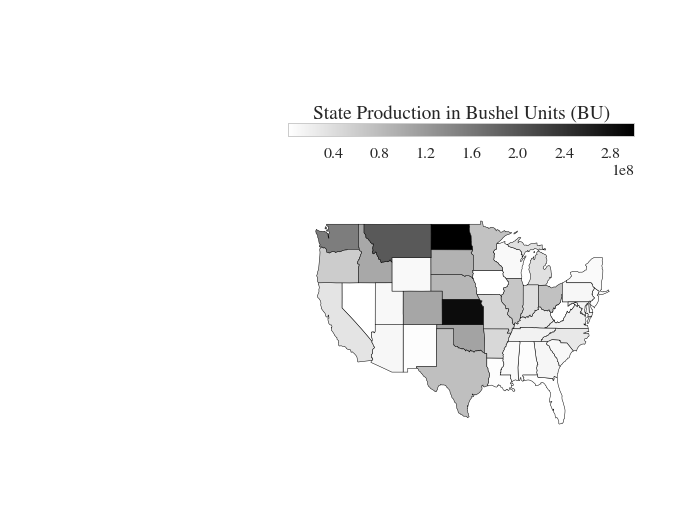

In [52]:
make_map(wheatproduction.loc[wheatproduction['Year'] == 1995].set_index('State').Value,"State Production in Bushel Units (BU)")

Now let's make a bar graph for a more quantitative visualization.

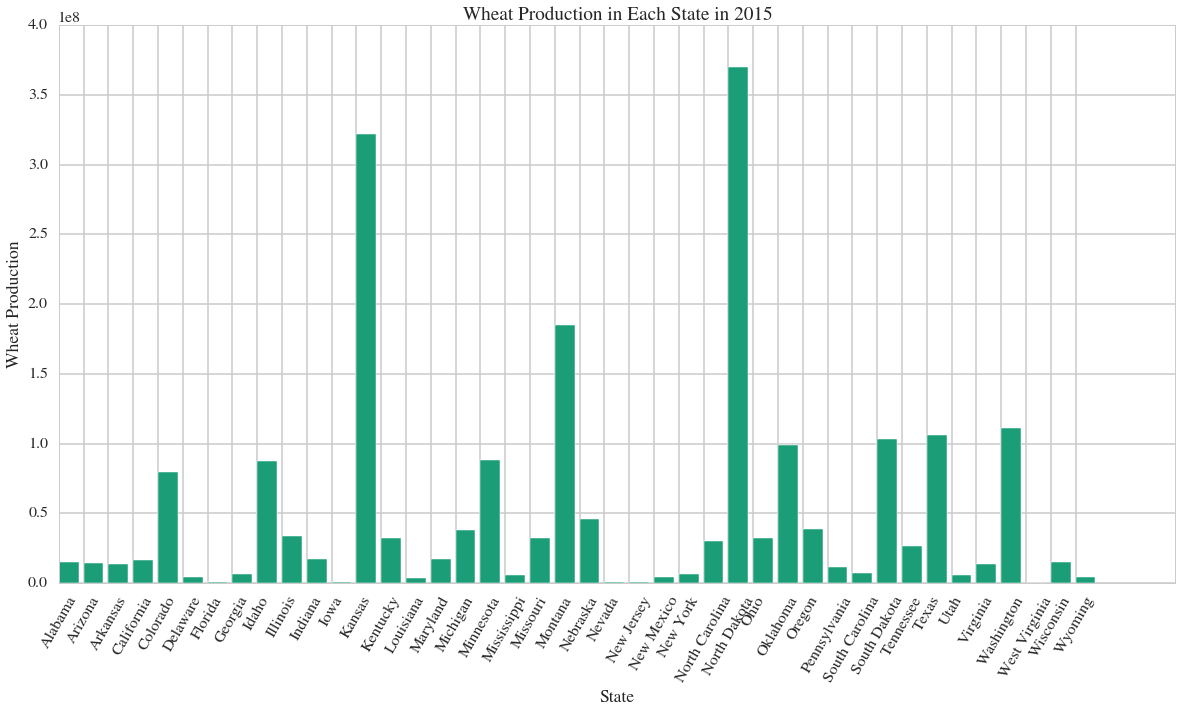

In [53]:
wheat_2015 = wheatproduction[wheatproduction['Year'] == 2015]
plt.figure(figsize=(20,10))
plt.bar(wheat_2015.index, wheat_2015.Value)
plt.xticks(wheat_2015.index, wheat_2015.State, rotation=60)
plt.xlabel('State')
plt.ylabel('Wheat Production')
plt.title('Wheat Production in Each State in 2015')

Analysis: From the heat map and bar graph, we can see that North Carolina, Kansas, and Montana produced the most wheat in the US. Let's sort the states by amount of wheat production.

In [54]:
wheat_2015.sort('Value', ascending=False)

,Unnamed: 0,Year,State,Value,CV (%)
27,27,2015,North Dakota,370023000,NaN
12,12,2015,Kansas,321900000,NaN
20,20,2015,Montana,185415000,NaN
38,38,2015,Washington,111540000,NaN
35,35,2015,Texas,106500000,NaN
33,33,2015,South Dakota,103406000,NaN
29,29,2015,Oklahoma,98800000,NaN
17,17,2015,Minnesota,88294000,NaN
8,8,2015,Idaho,87850000,NaN
4,4,2015,Colorado,79635000,NaN


We will need to consider the states that production the most wheat when incorporating the precipitation and temperature data in our model. To do this, we create a dictionary of the top 10 producers for each year.

In [55]:
grouped = wheatproduction.groupby('Year')
top_producers = {}
for k,v in grouped:
    states = list(v.sort('Value', ascending = False).State)
    abbrev = []
    for i in xrange(11):
        abbrev.append(rev_states[states[i]])
    top_producers[k] = abbrev

### 2.2 Visualizing Precipation Data
Here we will visualize precipation data with a heat map and bar graph.

In [56]:
prec = pd.read_csv("cleaned_data/precdf.csv")
prec.head(10)

,Unnamed: 0,State,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,AK,1995,7.123391,6.137565,5.789217,5.220609,7.546870,6.379043,8.656957,8.091478,16.222783,10.711130,6.080000,7.904696
1,1,AK,1996,3.767456,10.588509,5.155614,4.923596,2.425088,6.856404,5.376404,10.632544,11.493596,9.654737,5.764123,5.476842
2,2,AK,1997,7.787456,10.817193,4.292895,5.321579,4.591316,4.761930,8.129737,12.182456,13.685263,9.356140,11.094298,14.864386
3,3,AK,1998,5.331754,6.236579,5.311228,8.611842,7.783509,6.606053,9.086228,13.874649,11.543246,11.385702,6.267544,8.507456
4,4,AK,1999,9.033805,5.059115,7.488053,7.365310,6.638850,5.871416,7.139115,11.576903,15.863451,16.015221,9.392389,15.051593
5,5,AK,2000,10.022456,6.242632,8.913772,5.487456,4.314561,5.357895,9.188772,10.274035,12.989474,12.990088,12.621667,10.048421
6,6,AK,2001,16.756140,7.670877,8.158158,5.539561,6.994474,3.434298,10.253421,8.976842,11.873772,11.531053,6.698947,9.597544
7,7,AK,2002,10.582632,8.212895,3.262807,3.708246,4.331316,6.309474,6.724211,14.734386,13.097281,17.735263,15.101228,9.312368
8,8,AK,2003,7.911316,9.519386,4.834912,3.175526,5.372456,6.386842,7.816491,11.954649,10.839912,13.099386,9.507719,12.544035
9,9,AK,2004,7.157456,8.733070,6.829737,7.781491,4.779649,3.716053,5.877368,4.606053,14.338070,13.575351,13.587368,12.948772


We will remove non 50 state entries such as Puerto Rico and then visualize precipitation in a heat map of the United States.

In [57]:
for col in prec:
    if (col=='State'):
        prec= prec[(prec[col] != 'FM') & (prec[col] != 'UM')
                   & (prec[col] != 'MH') & (prec[col] != 'PW')]

In [58]:
def make_map_prec(year, start_month, end_month): 
    input_df = prec.loc[prec['Year'] == year]
    input_df['cumulative_rainfall'] = (prec.ix[:,start_month:end_month]).sum(axis=1)
    for index, row in input_df.iterrows():
        state_full=states_abbrev[row['State']]
        input_df['State'][index]=state_full
    make_map(input_df.set_index('State').cumulative_rainfall,"Total Rainfall in Inches by State from "+str(start_month)+" to "+str(end_month)+" "+str(year))

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


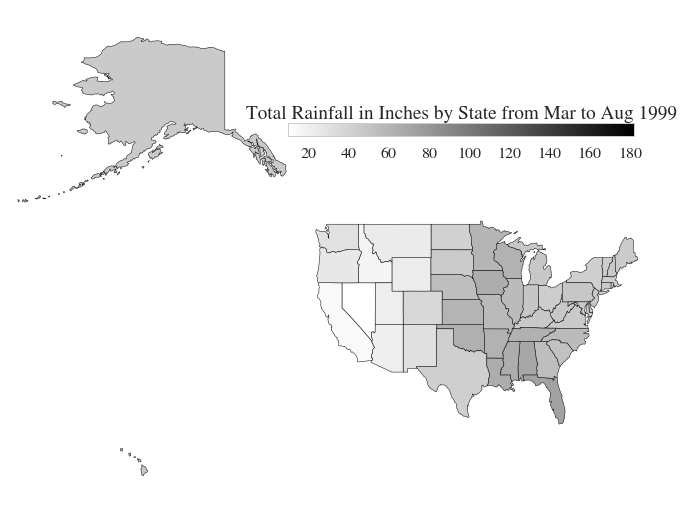

In [59]:
make_map_prec(1999,'Mar','Aug')

For a more quantitative understanding of the precipation in each state, we will make a bar graph.

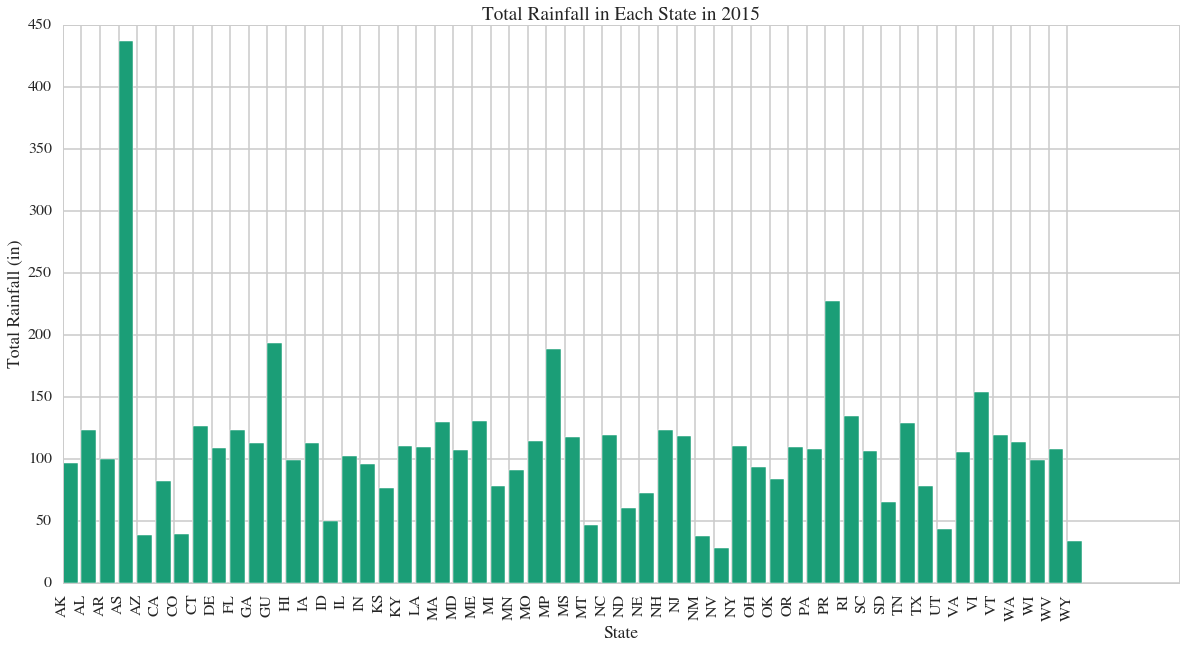

In [60]:
prec_2010 = prec[prec['Year'] == 2010].reset_index()
prec_2010['Total']=(prec_2010.ix[:,"Jan":'Dec']).sum(axis=1)
plt.figure(figsize=(20,10))
plt.bar(prec_2010.index, prec_2010.Total)
plt.xticks(prec_2010.index, prec_2010.State, rotation=90)
plt.xlabel('State')
plt.ylabel('Total Rainfall (in)')
plt.title('Total Rainfall in Each State in 2015')

### 2.3 Visualizing Temperature Data

We will use a heat map and bar graph to visualize the temperature data as well.

In [61]:
temp=pd.read_csv("cleaned_data/tempdf.csv")
temp.head()

,Unnamed: 0,State,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,AK,1995,-12.445260,-8.367532,-6.563247,2.549675,7.728182,11.788766,13.526364,11.594935,8.864935,0.430714,-7.723701,-11.932468
1,1,AK,1996,-16.260000,-13.498442,-6.184740,0.217078,6.951558,11.842403,13.753377,11.788052,7.029416,-2.241494,-9.112078,-13.413636
2,2,AK,1997,-13.658117,-5.749416,-5.873701,0.772532,6.700390,12.387532,13.926818,12.079545,8.146623,-1.473896,-4.614805,-8.935065
3,3,AK,1998,-9.501494,-7.298896,-4.462338,1.345455,5.668506,11.687597,13.703896,11.593896,7.624156,-0.392922,-7.814026,-13.244805
4,4,AK,1999,-11.512987,-12.314610,-7.826104,-1.812532,6.167078,11.702922,13.491558,12.104545,8.021429,1.039286,-4.866364,-9.715584


In [62]:
for col in temp:
    if (col=='State'):
        temp=temp[(temp[col] != 'FM') & (temp[col] != 'PR') & 
                  (temp[col] != 'UM') & (temp[col] != 'MH') & 
                  (temp[col] != 'PW')]

In [63]:
def make_map_temp(year, start_month, end_month): 
    input_df = temp.loc[temp['Year'] == year]
    input_df['mean_temp'] = (temp.ix[:,start_month:end_month]).mean(axis=1)
    for index, row in input_df.iterrows():
        state_full=states_abbrev[row['State']]
        input_df['State'][index]=state_full
    make_map(input_df.set_index('State').mean_temp,"Mean Temperature by State in Celsius from "+str(start_month)+" to "+str(end_month)+" "+str(year))

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


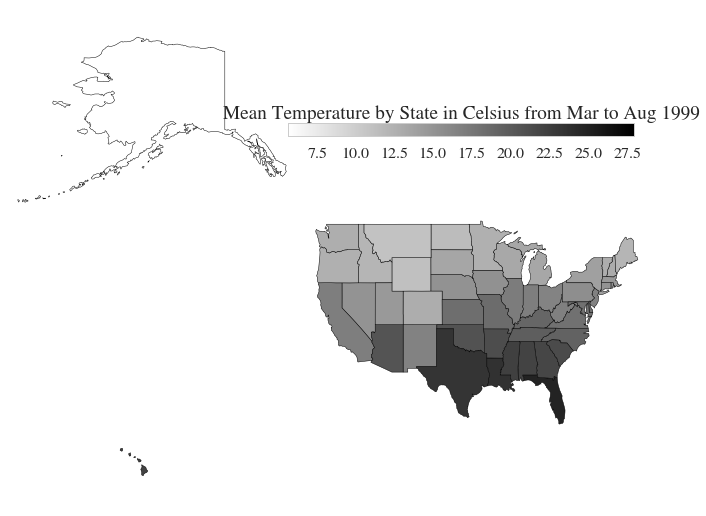

In [64]:
make_map_temp(1999,'Mar','Aug')

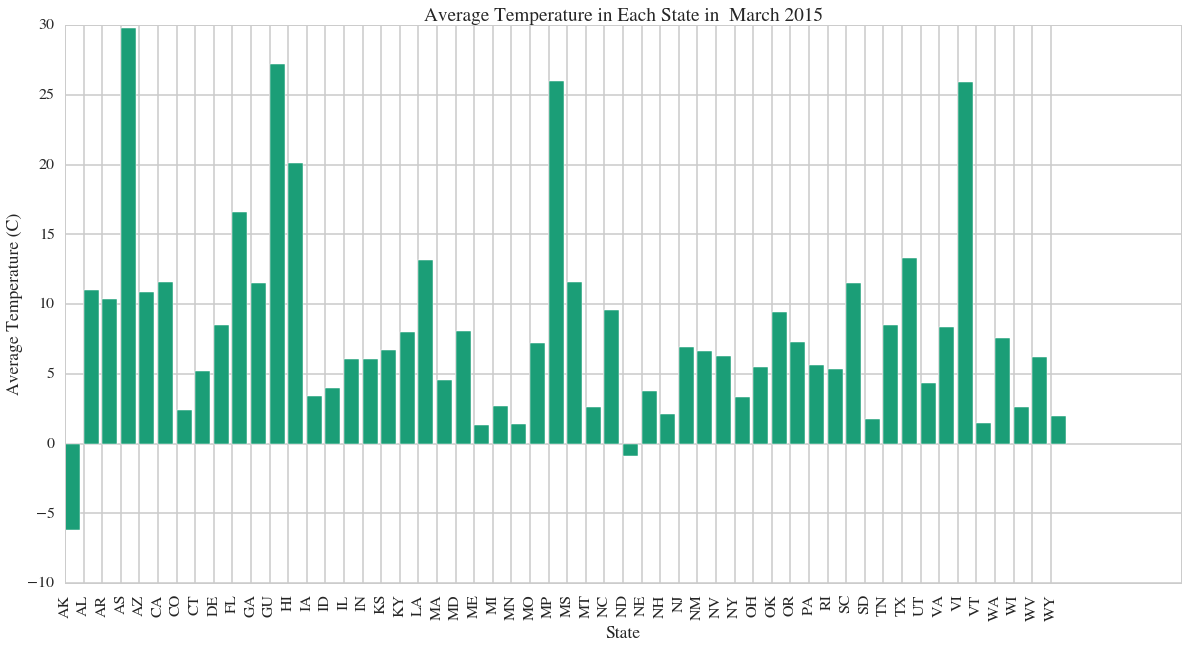

In [65]:
temp_2010 = temp[temp['Year'] == 2010].reset_index()
temp_2010['Total']=(temp_2010.ix[:,"Mar":'Mar']).mean(axis=1)
plt.figure(figsize=(20,10))
plt.bar(temp_2010.index, temp_2010.Total)
plt.xticks(temp_2010.index, temp_2010.State, rotation=90)
plt.xlabel('State')
plt.ylabel('Average Temperature (C)')
plt.title('Average Temperature in Each State in  March 2015')

##2.4 Visualizing Palmer Drought Severity Index
Here we visualize palmer drought severity in each state of a certain year. The more negative number signify higher areas of drought. We look at 2005, which has been recorded via media to have experienced drought in states like Arkansas.

In [66]:
def make_map_pdsi(year, start_month, end_month): 
    input_df = pdsi_station_df.loc[pdsi_station_df['Year'] == year]
    input_df['mean_pdsi'] = (pdsi_station_df.ix[:,start_month:end_month]).mean(axis=1)
    for index, row in input_df.iterrows():
        state_full=states_abbrev[row['State']]
        input_df['State'][index]=state_full
    make_map(input_df.set_index('State').mean_pdsi,"Mean Palmer Drought Severity Index by State from "+str(start_month)+" to "+str(end_month)+" "+str(year))

In [67]:
test=pdsi_station_df[pdsi_station_df['Year']==2005]
test.head()

,State,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
10,AL,2005,0.987500,0.781250,0.593750,1.200000,0.806250,1.705000,2.658750,3.012500,1.352500,-0.766250,-0.855000,-1.013750
26,AR,2005,0.717778,-0.441111,-0.763333,-0.872222,-1.507778,-2.015556,-2.027778,-2.161111,-1.844444,-2.555556,-2.803333,-3.557778
42,AZ,2005,3.171429,4.650000,4.274286,4.381429,4.982857,4.522857,0.582857,0.800000,-0.910000,-0.718571,-1.440000,-2.064286
58,CA,2005,2.312857,2.445714,2.712857,2.655714,3.710000,4.064286,4.354286,3.922857,3.437143,3.038571,0.958571,1.597143
74,CO,2005,1.192000,1.130000,0.944000,0.964000,-0.244000,0.078000,-0.860000,-0.544000,-0.860000,0.896000,-0.464000,-0.618000


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


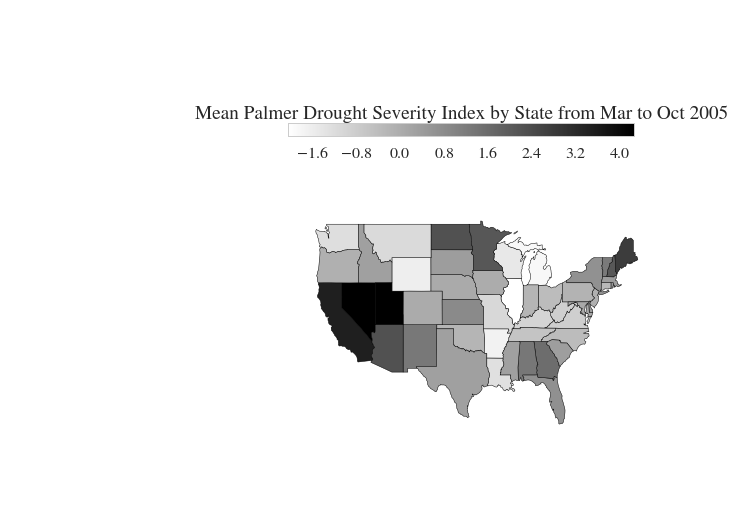

In [68]:
make_map_pdsi(2005,'Mar','Oct')

We can see that Arkansas is much lighter, which means it is experiencing heavier drought than other states. This corroborates our information from media sources, so we will continue using this data, as it seems reliable.

### 2.5 Visualizing Corn Price Data
Here we will visualize the price of corn using a line graph.

In [69]:
cornprice = pd.read_csv("cleaned_data/cornpricedf.csv")
cornprice.head()

,Unnamed: 0,Year,Month,Corn_Price,CP_%_Change
0,0,1995,Jan,106.90,4.23
1,1,1995,Feb,106.98,0.07
2,2,1995,Mar,109.63,2.48
3,3,1995,Apr,109.64,0.01
4,4,1995,May,111.93,2.09


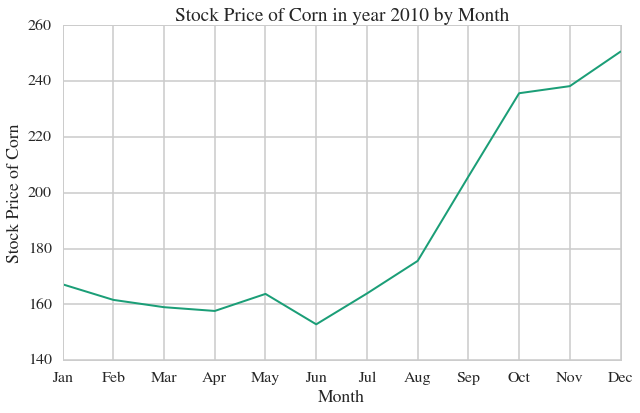

In [70]:
cornprice_2014 = cornprice[cornprice['Year'] == 2010].reset_index()
plt.xticks(cornprice_2014.index, cornprice_2014.Month)
plt.plot(cornprice_2014['Corn_Price'])
plt.xlabel('Month')
plt.ylabel('Stock Price of Corn')
plt.title('Stock Price of Corn in year 2010 by Month')

##2.5 Comparing Wheat Price to Features
Now that we've been able to visualize some of our data, we want to visualize how it compares to wheat price. The first step involves creating a large dataset, and then we will work on our EDA visualizations.

###2.5.1 Compiling Dataset
We want to compile our standardized datasets into one large dataset, while also adding the values of our top 10 wheat_producing states.

In [71]:
def add_top_10(dataset,letter):
    for i in np.arange(1,11):
        dataset[str(i)+'_'+letter] = dataset['Year'].map(lambda x: top_producers[x][i-1]+'_'+letter)
    for i in np.arange(1,11):
        dataset[str(i)+'_'+letter] = dataset[dataset[str(i)+'_'+letter]]
    return dataset

In [72]:
temp_df=add_top_10(temp_df,'T')
temp_df.head()

,Year,Month,AK_T,AL_T,AR_T,AS_T,AZ_T,CA_T,CO_T,CT_T,DE_T,FL_T,FM_T,GA_T,GU_T,HI_T,IA_T,ID_T,IL_T,IN_T,KS_T,KY_T,LA_T,MA_T,MD_T,ME_T,MH_T,MI_T,MN_T,MO_T,MP_T,MS_T,MT_T,NC_T,ND_T,NE_T,NH_T,NJ_T,NM_T,NV_T,NY_T,OH_T,OK_T,OR_T,PA_T,PR_T,PW_T,RI_T,SC_T,SD_T,TN_T,TX_T,UM_T,UT_T,VA_T,VI_T,VT_T,WA_T,WI_T,WV_T,WY_T,1_T,2_T,3_T,4_T,5_T,6_T,7_T,8_T,9_T,10_T
0,1995,Jan,-12.445260,8.542069,6.305050,28.25,6.127812,8.175129,-2.296887,0.031304,3.881111,15.756058,27.140000,8.685357,26.20,19.248163,-6.024234,-1.908971,-1.634156,-0.077941,0.709490,3.546892,10.926322,-0.184746,3.548125,-6.188906,27.100,-3.970000,-9.737949,0.674795,25.000,8.645341,-6.051947,5.849203,-11.969180,-3.626062,-3.83600,2.207333,1.788935,1.333860,-1.604737,0.190081,4.85936,3.160053,0.605407,23.656774,25.950,1.17750,8.001882,-6.796111,5.054530,9.807940,25.970,-0.892147,3.837264,22.578,-4.383514,2.167821,-6.624125,1.794045,-5.128015,-11.969180,0.709490,-6.051947,2.167821,4.85936,-2.296887,-1.908971,-6.796111,-3.626062,9.807940
1,1995,Feb,-8.367532,9.600230,8.183267,28.35,9.597750,10.683295,1.233585,-0.691739,2.833333,16.187591,26.858333,9.339554,26.30,19.467959,-0.214234,1.241985,2.162792,1.674510,5.381210,4.537568,12.119655,-0.966102,2.768958,-5.833906,27.175,-2.724453,-4.541282,4.623630,24.250,9.784886,-0.752566,5.909783,-4.368770,2.377938,-4.20900,1.009556,5.483432,5.724561,-2.788882,0.762258,8.08976,5.911223,-0.186148,23.726452,26.100,0.51000,8.226235,-0.584306,6.102479,11.911921,26.325,3.533865,3.736981,23.354,-5.120541,5.144744,-3.014875,2.213146,-1.565344,-4.368770,5.381210,-0.752566,5.144744,8.08976,1.233585,1.241985,-0.584306,2.377938,11.911921
2,1995,Mar,-6.563247,13.407586,11.306535,28.50,10.953062,10.460029,2.182358,3.839130,8.026667,18.254599,26.958333,13.369286,26.45,20.303878,2.270657,2.529412,6.215714,6.378137,5.781338,9.490811,14.565057,3.157288,8.069167,-0.955781,27.475,1.450365,-1.288333,7.683425,25.465,13.399773,-0.407832,10.631522,-4.442377,2.035937,0.96475,6.223111,6.711716,5.259211,2.871842,6.005887,9.23184,5.965851,5.309111,23.684839,26.375,4.03000,12.669765,-1.085486,10.890598,13.203935,26.125,4.136258,8.734528,22.794,0.763784,6.519679,0.688937,7.193483,-0.494198,-4.442377,5.781338,-0.407832,6.519679,9.23184,2.182358,2.529412,-1.085486,2.035937,13.203935
3,1995,Apr,2.549675,17.367816,15.637624,28.05,13.171062,12.240172,5.137547,8.179130,12.348889,21.452628,27.163333,17.552589,26.60,20.748163,8.618613,6.381838,10.801429,10.868431,11.106624,13.772703,18.230460,7.348136,12.595417,4.268438,27.725,5.351460,5.059808,12.614658,26.085,17.303182,5.261549,15.107029,4.751311,7.477313,5.19750,10.211111,9.398876,8.010702,6.505132,9.776935,14.00440,7.880266,8.936593,24.911935,26.800,8.28875,17.479294,5.174306,14.983932,17.475880,26.675,7.305583,13.073585,24.630,4.611892,8.706282,5.637187,11.224157,4.180992,4.751311,11.106624,5.261549,8.706282,14.00440,5.137547,6.381838,5.174306,7.477313,17.475880
4,1995,May,7.728182,22.526092,21.035545,28.05,17.448750,14.499083,9.870943,14.358696,17.602222,25.332701,27.590000,22.786161,26.95,21.555510,15.660365,11.039338,17.245260,17.139216,16.330382,18.938784,23.972989,13.837797,17.801667,11.892344,28.225,13.527226,13.532179,18.064795,26.625,22.544091,10.461195,19.628478,12.130246,13.204438,12.74075,16.028222,14.882012,11.563772,14.065921,16.429677,19.51632,12.472872,15.576000,25.909355,27.050,14.12000,22.381647,12.327292,19.919744,23.262106,27.110,11.355153,17.930566,26.170,13.028649,14.037115,13.794813,16.531124,8.674275,12.130246,16.330382,10.461195,14.037115,19.51632,9.870943,11.039338,12.327292,13.204438,23.262106


In [73]:
prec_df=add_top_10(prec_df,'P')
prec_df.head()

,Year,Month,AK_P,AL_P,AR_P,AS_P,AZ_P,CA_P,CO_P,CT_P,DE_P,FL_P,FM_P,GA_P,GU_P,HI_P,IA_P,ID_P,IL_P,IN_P,KS_P,KY_P,LA_P,MA_P,MD_P,ME_P,MH_P,MI_P,MN_P,MO_P,MP_P,MS_P,MT_P,NC_P,ND_P,NE_P,NH_P,NJ_P,NM_P,NV_P,NY_P,OH_P,OK_P,OR_P,PA_P,PR_P,PW_P,RI_P,SC_P,SD_P,TN_P,TX_P,UM_P,UT_P,VA_P,VI_P,VT_P,WA_P,WI_P,WV_P,WY_P,1_P,2_P,3_P,4_P,5_P,6_P,7_P,8_P,9_P,10_P
0,1995,Jan,7.123391,12.065317,12.828417,45.315,6.001897,35.020968,1.809312,10.072121,8.63750,8.294017,19.651667,11.719855,6.812,8.438039,2.174464,5.955776,8.018571,7.377055,2.547850,12.126985,16.164364,9.780779,9.549333,10.797273,17.861667,5.955338,1.576625,8.159162,7.3075,12.813333,1.530508,15.100126,1.222044,1.226958,9.0586,8.541111,2.225137,5.505149,7.847409,9.528387,5.107337,20.719529,8.705515,6.266154,39.515,8.60000,14.228710,0.941528,13.564510,5.145753,1.545,4.679879,13.304882,5.488462,7.754884,13.978344,2.230632,12.320000,1.618397,1.222044,2.547850,1.530508,13.978344,5.107337,1.809312,5.955776,0.941528,1.226958,5.145753
1,1995,Feb,6.137565,15.365794,5.075683,52.980,3.912414,3.441911,2.147018,7.275455,5.58250,4.912137,19.971111,15.927754,2.620,9.696569,0.837857,3.005948,2.606652,3.061507,0.851263,7.871471,8.313576,7.049221,4.954222,6.858961,13.705000,2.568195,1.057625,3.617095,3.7850,9.596822,1.219280,12.145849,0.916131,0.884667,6.4084,6.070185,1.200109,1.066436,5.545596,3.322839,1.266533,8.124241,5.020258,12.421231,34.260,8.09250,13.243226,1.157014,7.111275,2.924247,1.010,2.315333,5.517402,6.617692,5.637907,11.370000,0.893474,6.650851,1.532595,0.916131,0.851263,1.219280,11.370000,1.266533,2.147018,3.005948,1.157014,0.884667,2.924247
2,1995,Mar,5.789217,13.659206,8.472014,37.635,3.576724,25.546154,4.012477,5.876667,5.91750,8.098120,19.582222,8.271087,3.986,8.020196,6.332262,7.092500,6.101071,6.625411,5.798942,7.754779,23.626970,6.025844,4.671333,6.799870,14.660000,4.194060,6.208313,5.095028,0.8400,18.946512,3.124280,8.457233,3.656350,5.197042,6.5524,4.898889,1.786721,5.289010,4.272383,4.737032,7.932060,12.853194,4.428969,6.518769,27.655,6.11875,5.635591,4.988750,10.289902,7.215817,1.955,6.411455,5.921496,2.273846,5.700698,11.540446,5.439053,5.840319,2.475420,3.656350,5.798942,3.124280,11.540446,7.932060,4.012477,7.092500,4.988750,5.197042,7.215817
3,1995,Apr,5.220609,12.733651,15.554460,36.215,1.547011,6.499429,5.939266,6.909394,5.65875,9.294530,22.808333,5.445072,8.340,12.535392,12.473512,4.349914,11.354777,11.472877,7.415392,9.534632,21.958848,5.838182,6.040000,5.580390,50.935000,8.322406,6.214625,12.983408,5.7250,18.426744,3.989153,2.917547,2.496423,8.111917,4.9200,4.744074,1.841257,2.500198,5.816218,9.280710,11.394724,10.746806,6.249330,6.267231,7.180,7.71625,3.087419,8.754792,8.951471,7.770641,4.250,4.214545,4.271181,1.821538,5.436047,7.238981,7.950263,6.029255,4.120000,2.496423,7.415392,3.989153,7.238981,11.394724,5.939266,4.349914,8.754792,8.111917,7.770641
4,1995,May,7.546870,8.343413,13.002590,35.945,0.788908,4.212804,10.363165,7.938485,10.56000,7.977179,30.413889,6.660290,14.212,7.484118,15.281310,6.081552,22.131161,18.415137,24.332662,23.237132,18.258788,6.992987,11.430000,9.732597,21.553333,6.900827,8.112000,24.774134,10.6950,13.959225,6.572669,10.323082,8.134672,17.822125,7.5978,9.131852,3.607596,5.832574,5.583212,15.302000,18.445678,5.030995,9.757010,23.241538,34.920,8.15750,7.358495,13.960139,16.395196,13.212388,5.325,8.227636,12.583701,8.923077,5.862326,3.469490,9.304737,15.639787,9.620000,8.134672,24.332662,6.572669,3.469490,18.445678,10.363165,6.081552,13.960139,17.822125,13.212388


In [74]:
pdsi_df=add_top_10(pdsi_df,'D')
pdsi_df.head()

,Year,Month,AL_D,AR_D,AZ_D,CA_D,CO_D,CT_D,DE_D,FL_D,GA_D,IA_D,ID_D,IL_D,IN_D,KS_D,KY_D,LA_D,MA_D,MD_D,ME_D,MI_D,MN_D,MO_D,MS_D,MT_D,NC_D,ND_D,NE_D,NH_D,NJ_D,NM_D,NV_D,NY_D,OH_D,OK_D,OR_D,PA_D,RI_D,SC_D,SD_D,TN_D,TX_D,UT_D,VA_D,VT_D,WA_D,WI_D,WV_D,WY_D,1_D,2_D,3_D,4_D,5_D,6_D,7_D,8_D,9_D,10_D
0,1995,Jan,-0.43250,1.514444,1.932857,2.980000,0.958,-0.070000,-1.565,2.628571,1.398889,1.397778,0.974,0.984444,-0.857778,1.593333,-0.9200,0.032222,-0.443333,-1.55250,-0.563333,0.738,2.223333,1.760000,-0.205,-0.020000,0.24375,4.730000,3.06750,-0.970,-1.533333,1.32625,2.1475,-0.418,-0.574,1.563333,1.207778,0.745,-1.11,3.244286,2.926667,0.2275,0.040,1.881429,-0.101667,-1.096667,0.482,0.025556,-0.656667,1.581,4.730000,1.593333,-0.020000,0.482,1.563333,0.958,0.974,2.926667,3.06750,0.040
1,1995,Feb,-0.29000,-0.432222,1.951429,1.975714,0.852,-0.386667,-1.640,2.140000,1.793333,0.992222,0.587,0.426667,-1.178889,1.005556,-1.0225,-0.481111,-0.620000,-1.74750,-0.603333,-0.734,1.994444,1.381667,-0.525,-0.184286,0.39125,4.496667,2.64500,-1.025,-1.633333,0.14375,1.4875,-0.818,-1.101,0.547778,0.425556,-0.409,-1.08,3.412857,2.714444,-0.2575,-0.349,1.521429,-0.940000,-1.106667,0.411,-0.367778,-0.783333,1.515,4.496667,1.005556,-0.184286,0.411,0.547778,0.852,0.587,2.714444,2.64500,-0.349
2,1995,Mar,-0.57125,-0.818889,2.048571,4.122857,1.092,-1.060000,-2.120,1.800000,-0.312222,1.183333,1.426,0.054444,-1.391111,1.227778,-1.5700,1.117778,-1.140000,-2.35125,-0.850000,-0.978,2.542222,0.663333,0.200,0.275714,-0.60250,5.084444,2.77875,-1.210,-2.363333,0.01125,2.3775,-1.561,-1.717,0.861111,1.090000,-1.275,-1.61,1.381429,3.184444,-0.7400,0.014,2.175714,-1.480000,-1.393333,0.798,0.140000,-1.558333,1.780,5.084444,1.227778,0.275714,0.798,0.861111,1.092,1.426,3.184444,2.77875,0.014
3,1995,Apr,-0.49750,-0.042222,2.217143,4.267143,1.896,-1.410000,-2.415,1.797143,-0.887778,2.241111,1.533,0.621111,-0.171111,1.465556,-1.2175,1.866667,-1.560000,-2.51250,-1.140000,-0.270,2.372222,1.421667,0.663,1.345714,-1.51750,4.853333,3.27375,-1.625,-2.796667,0.06625,2.7875,-1.741,-0.523,1.336667,1.838889,-1.507,-1.86,0.404286,4.143333,-1.0575,0.036,2.495714,-2.003333,-1.643333,0.842,0.723333,-1.946667,2.205,4.853333,1.465556,1.345714,0.842,1.336667,1.896,1.533,4.143333,3.27375,0.036
4,1995,May,-0.75375,-0.106667,2.632857,4.682857,3.594,-1.486667,-1.990,1.242857,-1.352222,2.956667,2.067,2.363333,0.888889,3.661111,1.5350,0.861111,-1.726667,-1.80750,-0.846667,-0.545,2.036667,2.921667,0.324,1.731429,-1.52375,5.323333,4.94375,-1.685,-2.473333,0.33125,4.2750,-2.104,0.722,1.933333,1.743333,-1.478,-1.72,-0.085714,5.527778,0.3350,0.365,4.005714,-0.068333,-1.943333,0.429,0.553333,0.430000,3.703,5.323333,3.661111,1.731429,0.429,1.933333,3.594,2.067,5.527778,4.94375,0.365


Now, we delete the year and month columns of all the datasets except the first one we concatenate, so that we do not have repeating columns. Finally, we add them together.

In [75]:
inflation_df.head()

,Year,Month,Inflation
0,1995,Jan,0.40
1,1995,Feb,0.40
2,1995,Mar,0.33
3,1995,Apr,0.33
4,1995,May,0.20


In [76]:
del inflation_df['Year']
del inflation_df['Month']
del prec_df['Year']
del prec_df['Month']
del temp_df['Year']
del temp_df['Month']
del cornprice_df['Year']
del cornprice_df['Month']
del sorghumprice_df['Year']
del sorghumprice_df['Month']
del pdsi_df['Year']
del pdsi_df['Month']

We also want to make sure everything is in number form instead of string form.

In [77]:
dftouse=pd.concat([price_df, cornprice_df, sorghumprice_df, inflation_df, prec_df, temp_df, pdsi_df], axis=1)
for col in dftouse.columns:
    if col!='Month':
        dftouse[col]=dftouse[col].map(lambda x: float(x))
dftouse.head()

,Year,Month,Wheat_Price,WP_%_Change,Corn_Price,CP_%_Change,Sorghum_Price,SP_%_Change,Inflation,AK_P,AL_P,AR_P,AS_P,AZ_P,CA_P,CO_P,CT_P,DE_P,FL_P,FM_P,GA_P,GU_P,HI_P,IA_P,ID_P,IL_P,IN_P,KS_P,KY_P,LA_P,MA_P,MD_P,ME_P,MH_P,MI_P,MN_P,MO_P,MP_P,MS_P,MT_P,NC_P,ND_P,NE_P,NH_P,NJ_P,NM_P,NV_P,NY_P,OH_P,OK_P,...,GA_D,IA_D,ID_D,IL_D,IN_D,KS_D,KY_D,LA_D,MA_D,MD_D,ME_D,MI_D,MN_D,MO_D,MS_D,MT_D,NC_D,ND_D,NE_D,NH_D,NJ_D,NM_D,NV_D,NY_D,OH_D,OK_D,OR_D,PA_D,RI_D,SC_D,SD_D,TN_D,TX_D,UT_D,VA_D,VT_D,WA_D,WI_D,WV_D,WY_D,1_D,2_D,3_D,4_D,5_D,6_D,7_D,8_D,9_D,10_D
0,1995,Jan,156.21,-5.11,106.90,4.23,101.74,1.11,0.40,7.123391,12.065317,12.828417,45.315,6.001897,35.020968,1.809312,10.072121,8.63750,8.294017,19.651667,11.719855,6.812,8.438039,2.174464,5.955776,8.018571,7.377055,2.547850,12.126985,16.164364,9.780779,9.549333,10.797273,17.861667,5.955338,1.576625,8.159162,7.3075,12.813333,1.530508,15.100126,1.222044,1.226958,9.0586,8.541111,2.225137,5.505149,7.847409,9.528387,5.107337,...,1.398889,1.397778,0.974,0.984444,-0.857778,1.593333,-0.9200,0.032222,-0.443333,-1.55250,-0.563333,0.738,2.223333,1.760000,-0.205,-0.020000,0.24375,4.730000,3.06750,-0.970,-1.533333,1.32625,2.1475,-0.418,-0.574,1.563333,1.207778,0.745,-1.11,3.244286,2.926667,0.2275,0.040,1.881429,-0.101667,-1.096667,0.482,0.025556,-0.656667,1.581,4.730000,1.593333,-0.020000,0.482,1.563333,0.958,0.974,2.926667,3.06750,0.040
1,1995,Feb,154.42,-1.15,106.98,0.07,102.07,0.32,0.40,6.137565,15.365794,5.075683,52.980,3.912414,3.441911,2.147018,7.275455,5.58250,4.912137,19.971111,15.927754,2.620,9.696569,0.837857,3.005948,2.606652,3.061507,0.851263,7.871471,8.313576,7.049221,4.954222,6.858961,13.705000,2.568195,1.057625,3.617095,3.7850,9.596822,1.219280,12.145849,0.916131,0.884667,6.4084,6.070185,1.200109,1.066436,5.545596,3.322839,1.266533,...,1.793333,0.992222,0.587,0.426667,-1.178889,1.005556,-1.0225,-0.481111,-0.620000,-1.74750,-0.603333,-0.734,1.994444,1.381667,-0.525,-0.184286,0.39125,4.496667,2.64500,-1.025,-1.633333,0.14375,1.4875,-0.818,-1.101,0.547778,0.425556,-0.409,-1.08,3.412857,2.714444,-0.2575,-0.349,1.521429,-0.940000,-1.106667,0.411,-0.367778,-0.783333,1.515,4.496667,1.005556,-0.184286,0.411,0.547778,0.852,0.587,2.714444,2.64500,-0.349
2,1995,Mar,150.39,-2.61,109.63,2.48,102.74,0.66,0.33,5.789217,13.659206,8.472014,37.635,3.576724,25.546154,4.012477,5.876667,5.91750,8.098120,19.582222,8.271087,3.986,8.020196,6.332262,7.092500,6.101071,6.625411,5.798942,7.754779,23.626970,6.025844,4.671333,6.799870,14.660000,4.194060,6.208313,5.095028,0.8400,18.946512,3.124280,8.457233,3.656350,5.197042,6.5524,4.898889,1.786721,5.289010,4.272383,4.737032,7.932060,...,-0.312222,1.183333,1.426,0.054444,-1.391111,1.227778,-1.5700,1.117778,-1.140000,-2.35125,-0.850000,-0.978,2.542222,0.663333,0.200,0.275714,-0.60250,5.084444,2.77875,-1.210,-2.363333,0.01125,2.3775,-1.561,-1.717,0.861111,1.090000,-1.275,-1.61,1.381429,3.184444,-0.7400,0.014,2.175714,-1.480000,-1.393333,0.798,0.140000,-1.558333,1.780,5.084444,1.227778,0.275714,0.798,0.861111,1.092,1.426,3.184444,2.77875,0.014
3,1995,Apr,148.98,-0.94,109.64,0.01,103.29,0.54,0.33,5.220609,12.733651,15.554460,36.215,1.547011,6.499429,5.939266,6.909394,5.65875,9.294530,22.808333,5.445072,8.340,12.535392,12.473512,4.349914,11.354777,11.472877,7.415392,9.534632,21.958848,5.838182,6.040000,5.580390,50.935000,8.322406,6.214625,12.983408,5.7250,18.426744,3.989153,2.917547,2.496423,8.111917,4.9200,4.744074,1.841257,2.500198,5.816218,9.280710,11.394724,...,-0.887778,2.241111,1.533,0.621111,-0.171111,1.465556,-1.2175,1.866667,-1.560000,-2.51250,-1.140000,-0.270,2.372222,1.421667,0.663,1.345714,-1.51750,4.853333,3.27375,-1.625,-2.796667,0.06625,2.7875,-1.741,-0.523,1.336667,1.838889,-1.507,-1.86,0.404286,4.143333,-1.0575,0.036,2.495714,-2.003333,-1.643333,0.842,0.723333,-1.946667,2.205,4.853333,1.465556,1.345714,0.842,1.336667,1.896,1.533,4.143333,3.27375,0.036
4,1995,May,158.61,6.46,111.93,2.09,108.06,4.62,0.20,7.546870,8.343413,13.002590,35.945,0.788908,4.212804,10.3

In [78]:
dftouse.to_csv('cleaned_data/dftouse.csv')

###2.5.2 Generating Plots of Wheat Price vs. Economic Factors
We next generate graphs relating each variable, excluding temperature and precipitation, to Wheat Price. Hopefully we will be able to see some correlation in a few factors, which we will be able to use in our model. We will also skip month for now because they repeat, so a scatter plot would be more appropriate.

In [79]:
cols=['Year','Corn_Price','CP_%_Change','Inflation','Wheat_Price','WP_%_Change','Sorghum_Price','SP_%_Change']

//anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


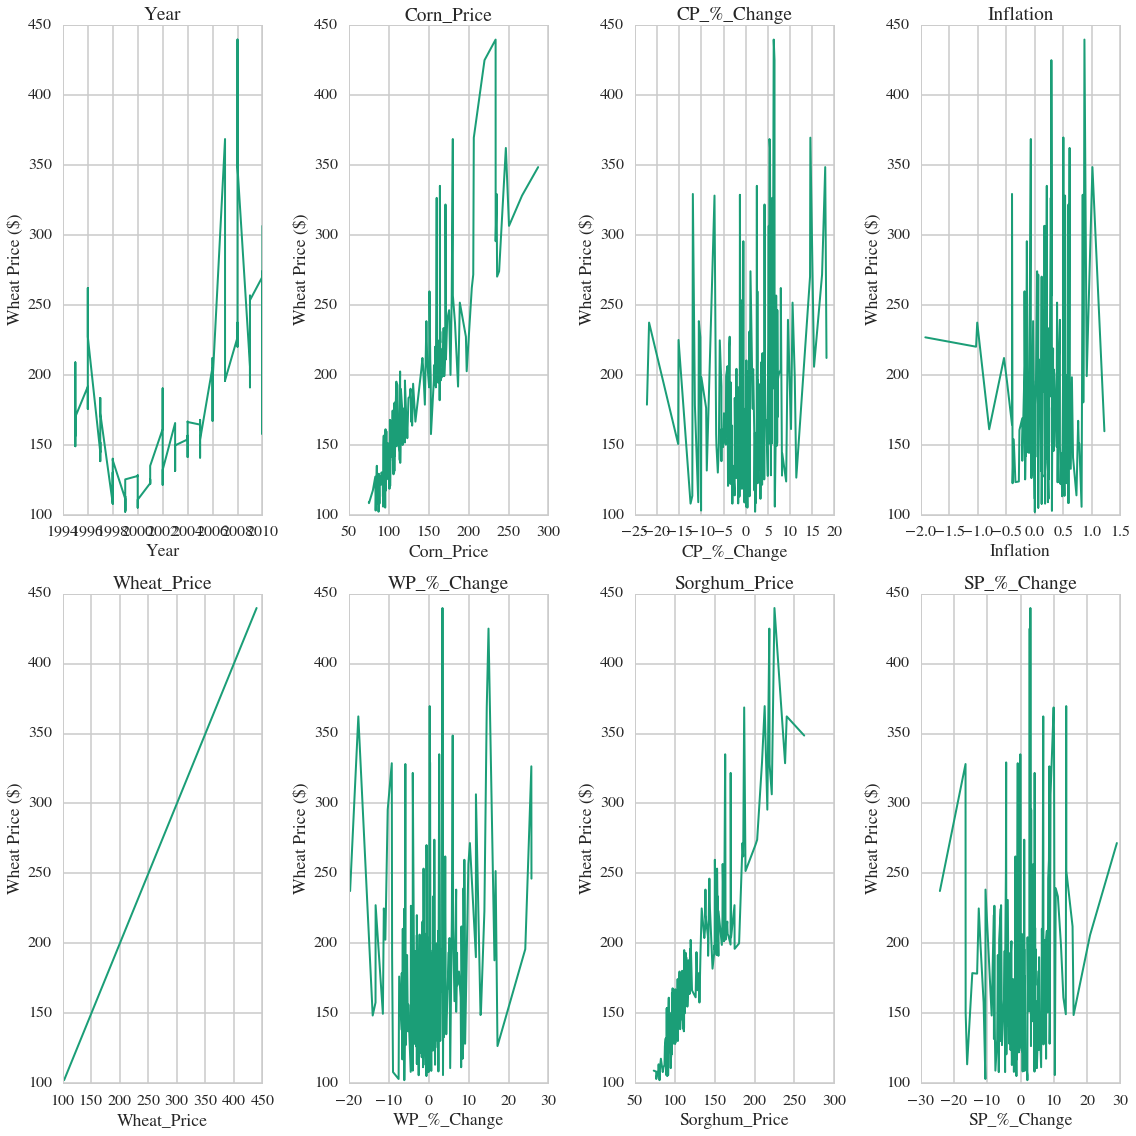

In [80]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 16), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), cols):
    dftograph=dftouse.sort([p]).set_index(p).reset_index()
    ax.plot(dftograph[p], dftograph['Wheat_Price'])
    ax.set_title(p)
    ax.set_ylabel('Wheat Price ($)')
    ax.set_xlabel(p)

###2.5.3 Generating Plots of Wheat Price vs. Climate Factors
Now we want to use scatter plots to examine the relationship between Wheat Price and Precipitation. First we look at the relationship between Wheat Price and Precipitation at a monthly level. Specifically, we look at the 5 states with largest wheat production (Kansas, North Dakota, Montana, Washington, Idaho) individually first, and then we look at the average of all states in dftouse. 

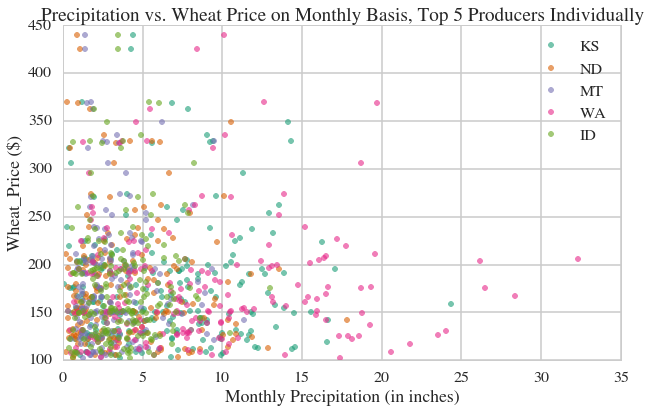

In [81]:
#Top 5 wheat producers, individually 
plt.xlabel('Monthly Precipitation (in inches)')
plt.ylabel('Wheat_Price ($)')
plt.plot(dftouse["KS_P"],dftouse['Wheat_Price'], '.', alpha=.6)
plt.plot(dftouse["ND_P"],dftouse['Wheat_Price'], '.', alpha=.6)
plt.plot(dftouse["MT_P"],dftouse['Wheat_Price'], '.', alpha=.6)
plt.plot(dftouse["WA_P"],dftouse['Wheat_Price'], '.', alpha=.6)
plt.plot(dftouse["ID_P"],dftouse['Wheat_Price'], '.', alpha=.6)
states = ['KS','ND','MT','WA','ID']
plt.legend(states)
plt.title('Precipitation vs. Wheat Price on Monthly Basis, Top 5 Producers Individually')

We now average these top 5 producers for a clearer visualization. 

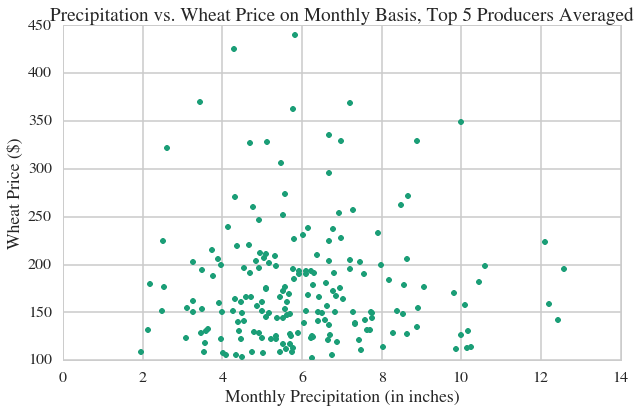

In [82]:
#Top 5 producers averaged
plt.plot(dftouse.ix[:,'1_P':'5_P'].mean(axis=1),dftouse[['Wheat_Price']].mean(axis=1),'.')
plt.xlabel('Monthly Precipitation (in inches) ')
plt.ylabel('Wheat Price ($)')
plt.title('Precipitation vs. Wheat Price on Monthly Basis, Top 5 Producers Averaged')

We also look at the average for all states. 

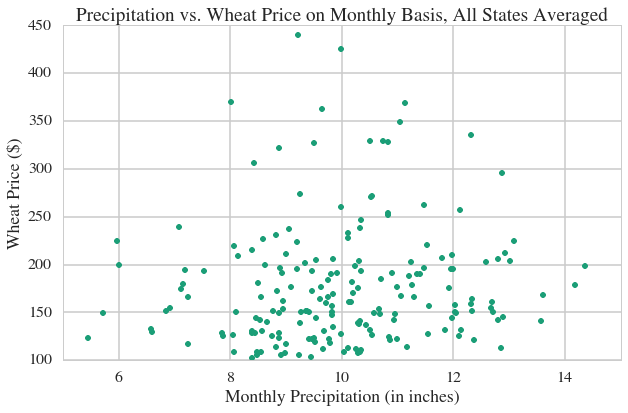

In [83]:
#All states 
plt.plot(dftouse.ix[:,'AK_P':'WY_P'].mean(axis=1),dftouse['Wheat_Price'],'.')
plt.ylabel('Wheat Price ($)')
plt.xlabel('Monthly Precipitation (in inches)')
plt.title('Precipitation vs. Wheat Price on Monthly Basis, All States Averaged')

We then examine the correlation between precipitation and wheat price for the same 5 states, but only for March through October, which is growing season through harvest.

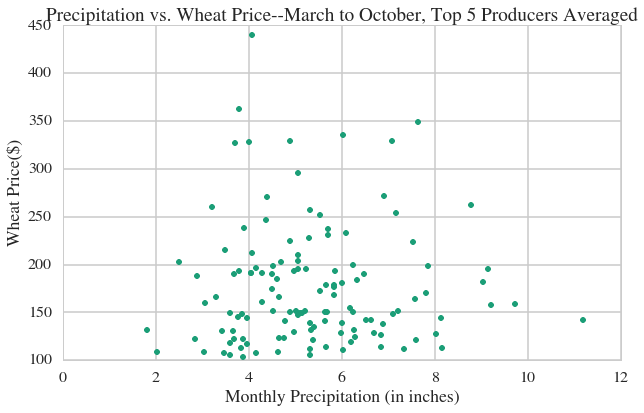

In [84]:
#Top 5 producers averaged, March through October 
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
dftouse_Mar_to_Oct = dftouse.loc[dftouse['Month'].isin(months)]
plt.plot(dftouse_Mar_to_Oct[["KS_P", "MT_P","ND_P","WA_P","ID_P"]].mean(axis=1),dftouse_Mar_to_Oct['Wheat_Price'],'.')
plt.ylabel('Wheat Price($)')
plt.xlabel('Monthly Precipitation (in inches)')
plt.title('Precipitation vs. Wheat Price--March to October, Top 5 Producers Averaged')

Now we visualize the same five states for wheat price vs. precipitation, but at an annual scale. We hope that less resolution might make seeing trends easier. 

In [85]:
dftouse_year = dftouse.groupby(['Year']).mean().reset_index()
dftouse_year.head()

,Year,Wheat_Price,WP_%_Change,Corn_Price,CP_%_Change,Sorghum_Price,SP_%_Change,Inflation,AK_P,AL_P,AR_P,AS_P,AZ_P,CA_P,CO_P,CT_P,DE_P,FL_P,FM_P,GA_P,GU_P,HI_P,IA_P,ID_P,IL_P,IN_P,KS_P,KY_P,LA_P,MA_P,MD_P,ME_P,MH_P,MI_P,MN_P,MO_P,MP_P,MS_P,MT_P,NC_P,ND_P,NE_P,NH_P,NJ_P,NM_P,NV_P,NY_P,OH_P,OK_P,OR_P,...,GA_D,IA_D,ID_D,IL_D,IN_D,KS_D,KY_D,LA_D,MA_D,MD_D,ME_D,MI_D,MN_D,MO_D,MS_D,MT_D,NC_D,ND_D,NE_D,NH_D,NJ_D,NM_D,NV_D,NY_D,OH_D,OK_D,OR_D,PA_D,RI_D,SC_D,SD_D,TN_D,TX_D,UT_D,VA_D,VT_D,WA_D,WI_D,WV_D,WY_D,1_D,2_D,3_D,4_D,5_D,6_D,7_D,8_D,9_D,10_D
0,1995,176.960000,2.119167,123.452500,3.150000,118.971667,3.595833,0.209167,7.988645,12.734848,9.054077,36.065833,2.491887,7.743044,3.987125,9.134899,8.479688,12.866261,27.594583,10.903478,16.870667,9.242443,6.889668,4.852457,8.230978,8.110131,6.767955,10.143480,13.674798,8.676342,8.437241,8.971472,27.836250,6.905025,6.408974,8.957868,16.808125,12.423114,3.853506,11.763983,4.155979,5.454045,8.915300,8.603873,2.533379,2.458738,7.772232,8.309919,8.308057,9.830432,...,0.236019,0.750093,2.661333,-0.009444,-0.629074,1.722500,0.024583,-0.031389,-0.869722,-1.265104,-0.652778,-0.371250,2.252315,0.886944,0.021833,2.008690,0.589271,4.948333,2.587292,-0.983750,-1.448056,-0.472396,2.616042,-1.179500,-0.088083,1.188056,2.005278,-0.740000,-1.154167,1.962857,4.865278,0.388333,-0.033167,2.171429,-0.082639,-0.910278,1.240167,0.427593,-0.470000,3.583667,4.948333,1.722500,2.008690,1.240167,1.188056,2.554000,2.661333,4.865278,2.587292,-0.033167
1,1996,207.141667,-1.147500,164.523333,-1.528333,150.029167,-2.744167,0.273333,6.842909,12.497950,11.069245,32.045417,2.028983,7.180839,3.575745,12.932273,12.714792,11.280962,35.463640,10.774360,20.512167,13.368791,7.123244,4.791458,8.260022,10.249652,6.850503,12.039289,11.505778,12.759015,12.788667,11.021786,26.866944,7.162331,5.987646,9.314604,16.690417,11.805736,3.345639,12.049885,3.905852,5.828983,11.699833,12.672546,2.982532,2.195932,10.774413,9.997935,8.048735,12.040794,...,0.084722,0.602685,3.161500,0.432685,1.480556,0.607037,1.932500,-0.263889,2.714444,3.020000,2.471944,1.192583,2.027037,0.634028,-0.054833,2.542024,1.404896,3.913981,1.983542,2.963750,2.236667,-0.933542,0.167083,2.342000,2.228833,0.238056,3.350741,3.054417,1.655000,0.702143,5.073889,1.887500,-1.274583,-0.577381,2.612917,2.688056,2.920917,1.253333,3.195000,3.216250,3.913981,0.607037,2.542024,2.920917,0.238056,0.490000,3.161500,5.073889,1.983542,-1.274583
2,1997,159.665000,-1.447500,117.171667,-0.144167,109.621667,0.486667,0.140833,8.907054,13.276343,10.827728,31.179583,2.791014,4.540378,4.240845,9.368636,8.718958,13.001880,28.830637,12.303327,24.734167,12.820850,6.276116,3.980093,7.467783,8.401513,6.723797,10.495061,13.895066,8.670119,8.162889,8.261721,29.385417,6.501416,5.539328,8.428589,19.404583,13.834658,3.389933,9.991630,3.560505,4.879160,8.893167,9.351096,3.954176,1.845033,8.240427,8.074710,8.550959,8.041928,...,0.750093,0.498981,3.188750,0.106574,1.613333,1.895000,1.228750,1.166759,-0.020556,0.073958,0.511111,0.814250,1.764259,1.402639,1.620667,2.122500,0.198333,2.235648,1.706667,1.503750,1.239167,1.482500,0.624583,1.381333,2.209250,2.910000,2.846944,0.521417,-0.170833,1.090238,6.286204,3.077917,1.782500,2.187024,0.135417,1.846111,3.588583,0.317037,1.968611,3.183750,2.235648,1.895000,2.122500,3.588583,2.910000,1.923167,3.188750,6.286204,1.706667,1.782500
3,1998,126.096667,-0.930000,101.616667,-1.310000,98.037500,-1.598333,0.132500,8.378816,12.606124,10.556313,21.809167,3.136594,8.076729,3.524698,10.663914,8.668229,11.948419,21.048284,11.306341,11.667667,8.667230,8.384449,4.606753,9.357705,9.520548,7.506883,10.396703,13.381939,10.727240,8.983685,9.882565,17.385278,6.445752,6.380083,10.604604,10.566042,12.227926,3.498139,11.332657,4.601825,5.819156,9.727150,9.049846,2.954221,3.003144,8.626187,8.464909,7.867668,10.126047,...,0.151944,1.625463,2.058000,0.846852,0.969074,1.980185,-0.487292,-0.084815,0.304722,0.187292,0.251944,-1.775083,1.088056,1.761667,-0.591917,0.466905,-0.008542,1.301481,1.86947

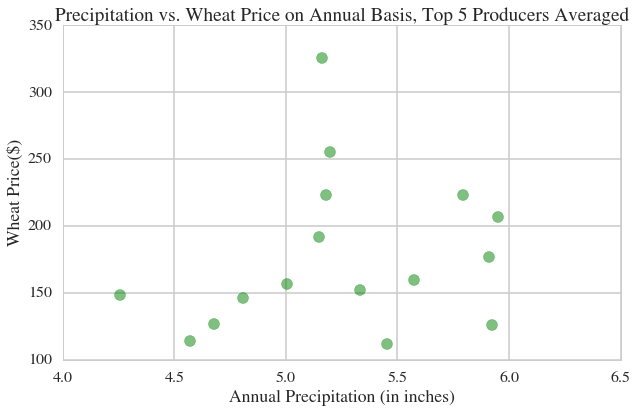

In [86]:
plt.scatter(dftouse_year[["KS_P", "MT_P","ND_P","WA_P","ID_P"]].mean(axis=1),dftouse_year['Wheat_Price'],s=120,alpha=.5,color='g')
plt.ylabel('Wheat Price($)')
plt.xlabel('Annual Precipitation (in inches)')
plt.title('Precipitation vs. Wheat Price on Annual Basis, Top 5 Producers Averaged')

Now we want to use scatter plots to examine the relationship between Wheat Price and Temperature. First we look at the relationship between Wheat Price and Temperature at a monthly level. Specifically, we look at the 5 states with largest wheat production (Kansas, North Dakota, Montana, Washington, Idaho) individually first, and then we look at the average of all states in dftouse. 

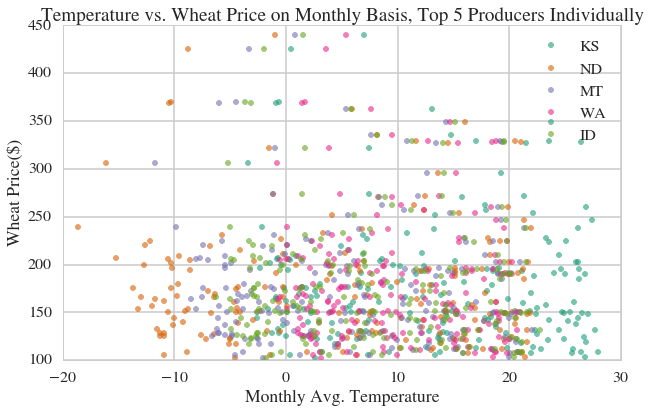

In [87]:
#Top 5 wheat producers, individually 
plt.ylabel('Wheat Price($)')
plt.xlabel('Monthly Avg. Temperature')
plt.plot(dftouse["KS_T"],dftouse['Wheat_Price'],'.', alpha=.6)
plt.plot(dftouse["ND_T"],dftouse['Wheat_Price'], '.', alpha=.6)
plt.plot(dftouse["MT_T"],dftouse['Wheat_Price'], '.', alpha=.6)
plt.plot(dftouse["WA_T"],dftouse['Wheat_Price'],'.', alpha=.6)
plt.plot(dftouse["ID_T"],dftouse['Wheat_Price'], '.', alpha=.6)
states = ['KS','ND','MT','WA','ID']
plt.legend(states)
plt.title('Temperature vs. Wheat Price on Monthly Basis, Top 5 Producers Individually')

We now average these top 5 producers for a clearer visualization.

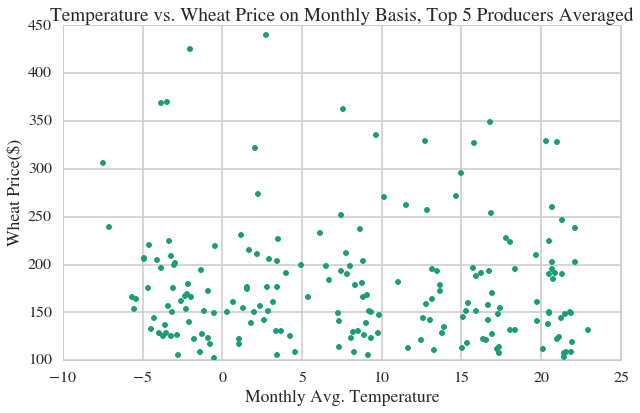

In [88]:
#Top 5 producers averaged
plt.plot(dftouse[["KS_T", "MT_T","ND_T","WA_T","ID_T"]].mean(axis=1),dftouse['Wheat_Price'],'.')
plt.ylabel('Wheat Price($)')
plt.xlabel('Monthly Avg. Temperature')
plt.title('Temperature vs. Wheat Price on Monthly Basis, Top 5 Producers Averaged')

We also look at all states. 

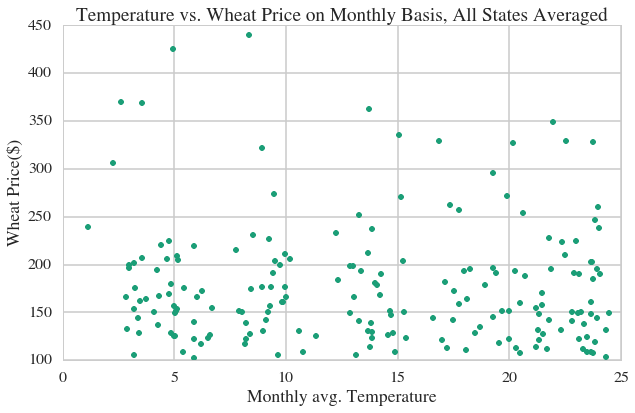

In [89]:
#All states 
plt.plot(dftouse.ix[:,'AK_T':'WY_T'].mean(axis=1),dftouse['Wheat_Price'],'.')
plt.ylabel('Wheat Price($)')
plt.xlabel('Monthly avg. Temperature')
plt.title('Temperature vs. Wheat Price on Monthly Basis, All States Averaged')

We then examine the correlation between temperature and wheat price for the same 5 states, but only for March through October, which is growing season through harvest.

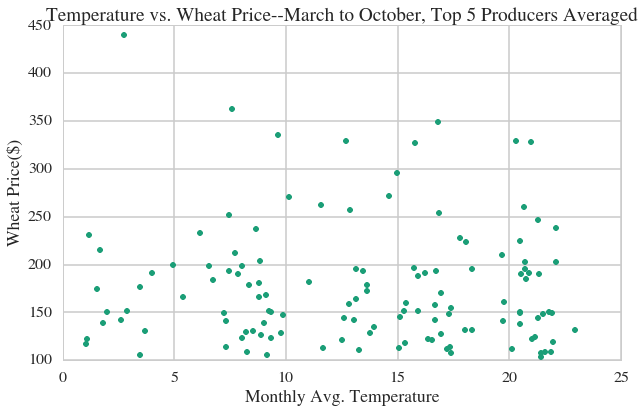

In [90]:
#Top 5 producers averaged, March through October 
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
dftouse_Mar_to_Oct = dftouse.loc[dftouse['Month'].isin(months)]
plt.plot(dftouse_Mar_to_Oct[["KS_T", "MT_T","ND_T","WA_T","ID_T"]].mean(axis=1),dftouse_Mar_to_Oct['Wheat_Price'],'.')
plt.ylabel('Wheat Price($)')
plt.xlabel('Monthly Avg. Temperature')
plt.title('Temperature vs. Wheat Price--March to October, Top 5 Producers Averaged')

Now we visualize the same five states for wheat price vs. temperature, but at an annual scale. We hope that less resolution might make seeing trends easier.

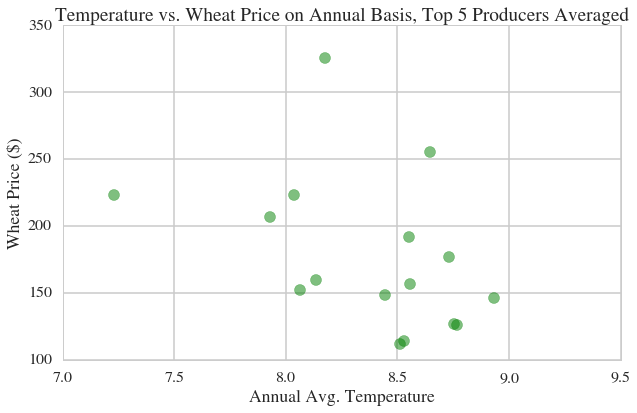

In [91]:
plt.scatter(dftouse_year[["KS_T", "MT_T","ND_T","WA_T","ID_T"]].mean(axis=1), dftouse_year['Wheat_Price'],s=120,alpha=.5,color='g')
plt.ylabel('Wheat Price ($)')
plt.xlabel('Annual Avg. Temperature')
plt.title('Temperature vs. Wheat Price on Annual Basis, Top 5 Producers Averaged')

Since we don't seem to be getting very clear correlations, we decided to try something different. We reasoned that the precipitation and temperature of one month might not have immediate effects on the price of that month, but it might have effects on following months. Precipitation had a better looking correlation than temperature did, so we plotted precipitation vs. an offset month's wheat price. We made a function that allowed us to plug in an offset number and the dataset, where it would return a dataset with a column that had the price that number of months into the future.

In [92]:
def offset(offset, dataset):
    next_price=[]
    for i in np.arange(len(dataset.index)-offset):
        next_price.append(dataset['Wheat_Price'][i+offset])
    dataset=dataset[:-offset]
    dataset['Next_Price']=next_price
    #Top 5 wheat producers, individually 
    plt.ylabel('Wheat_Price_in_'+str(offset)+'_Months($)')
    plt.xlabel('Monthly Precipitation (in inches)')
    plt.plot(dataset["KS_P"],dataset['Next_Price'], '.', alpha=.6)
    plt.plot(dataset["ND_P"],dataset['Next_Price'], '.', alpha=.6)
    plt.plot(dataset["MT_P"],dataset['Next_Price'], '.', alpha=.6)
    plt.plot(dataset["WA_P"],dataset['Next_Price'], '.', alpha=.6)
    plt.plot(dataset["ID_P"],dataset['Next_Price'], '.', alpha=.6)
    states = ['KS','ND','MT','WA','ID']
    plt.legend(states)
    plt.title('Precipitation vs. Wheat Price in '+str(offset)+' Month(s) on Monthly Basis, Top 5 Producers Individually')
    return dataset

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Year,Month,Wheat_Price,WP_%_Change,Corn_Price,CP_%_Change,Sorghum_Price,SP_%_Change,Inflation,AK_P,AL_P,AR_P,AS_P,AZ_P,CA_P,CO_P,CT_P,DE_P,FL_P,FM_P,GA_P,GU_P,HI_P,IA_P,ID_P,IL_P,IN_P,KS_P,KY_P,LA_P,MA_P,MD_P,ME_P,MH_P,MI_P,MN_P,MO_P,MP_P,MS_P,MT_P,NC_P,ND_P,NE_P,NH_P,NJ_P,NM_P,NV_P,NY_P,OH_P,OK_P,...,IA_D,ID_D,IL_D,IN_D,KS_D,KY_D,LA_D,MA_D,MD_D,ME_D,MI_D,MN_D,MO_D,MS_D,MT_D,NC_D,ND_D,NE_D,NH_D,NJ_D,NM_D,NV_D,NY_D,OH_D,OK_D,OR_D,PA_D,RI_D,SC_D,SD_D,TN_D,TX_D,UT_D,VA_D,VT_D,WA_D,WI_D,WV_D,WY_D,1_D,2_D,3_D,4_D,5_D,6_D,7_D,8_D,9_D,10_D,Next_Price
0,1995,Jan,156.21,-5.11,106.90,4.23,101.74,1.11,0.40,7.123391,12.065317,12.828417,45.315,6.001897,35.020968,1.809312,10.072121,8.63750,8.294017,19.651667,11.719855,6.812,8.438039,2.174464,5.955776,8.018571,7.377055,2.547850,12.126985,16.164364,9.780779,9.549333,10.797273,17.861667,5.955338,1.576625,8.159162,7.3075,12.813333,1.530508,15.100126,1.222044,1.226958,9.0586,8.541111,2.225137,5.505149,7.847409,9.528387,5.107337,...,1.397778,0.974,0.984444,-0.857778,1.593333,-0.9200,0.032222,-0.443333,-1.55250,-0.563333,0.738,2.223333,1.760000,-0.205,-0.020000,0.24375,4.730000,3.06750,-0.970,-1.533333,1.32625,2.1475,-0.418,-0.574,1.563333,1.207778,0.745,-1.11,3.244286,2.926667,0.2275,0.040,1.881429,-0.101667,-1.096667,0.482,0.025556,-0.656667,1.581,4.730000,1.593333,-0.020000,0.482,1.563333,0.958,0.974,2.926667,3.06750,0.040,148.98
1,1995,Feb,154.42,-1.15,106.98,0.07,102.07,0.32,0.40,6.137565,15.365794,5.075683,52.980,3.912414,3.441911,2.147018,7.275455,5.58250,4.912137,19.971111,15.927754,2.620,9.696569,0.837857,3.005948,2.606652,3.061507,0.851263,7.871471,8.313576,7.049221,4.954222,6.858961,13.705000,2.568195,1.057625,3.617095,3.7850,9.596822,1.219280,12.145849,0.916131,0.884667,6.4084,6.070185,1.200109,1.066436,5.545596,3.322839,1.266533,...,0.992222,0.587,0.426667,-1.178889,1.005556,-1.0225,-0.481111,-0.620000,-1.74750,-0.603333,-0.734,1.994444,1.381667,-0.525,-0.184286,0.39125,4.496667,2.64500,-1.025,-1.633333,0.14375,1.4875,-0.818,-1.101,0.547778,0.425556,-0.409,-1.08,3.412857,2.714444,-0.2575,-0.349,1.521429,-0.940000,-1.106667,0.411,-0.367778,-0.783333,1.515,4.496667,1.005556,-0.184286,0.411,0.547778,0.852,0.587,2.714444,2.64500,-0.349,158.61
2,1995,Mar,150.39,-2.61,109.63,2.48,102.74,0.66,0.33,5.789217,13.659206,8.472014,37.635,3.576724,25.546154,4.012477,5.876667,5.91750,8.098120,19.582222,8.271087,3.986,8.020196,6.332262,7.092500,6.101071,6.625411,5.798942,7.754779,23.626970,6.025844,4.671333,6.799870,14.660000,4.194060,6.208313,5.095028,0.8400,18.946512,3.124280,8.457233,3.656350,5.197042,6.5524,4.898889,1.786721,5.289010,4.272383,4.737032,7.932060,...,1.183333,1.426,0.054444,-1.391111,1.227778,-1.5700,1.117778,-1.140000,-2.35125,-0.850000,-0.978,2.542222,0.663333,0.200,0.275714,-0.60250,5.084444,2.77875,-1.210,-2.363333,0.01125,2.3775,-1.561,-1.717,0.861111,1.090000,-1.275,-1.61,1.381429,3.184444,-0.7400,0.014,2.175714,-1.480000,-1.393333,0.798,0.140000,-1.558333,1.780,5.084444,1.227778,0.275714,0.798,0.861111,1.092,1.426,3.184444,2.77875,0.014,169.98
3,1995,Apr,148.98,-0.94,109.64,0.01,103.29,0.54,0.33,5.220609,12.733651,15.554460,36.215,1.547011,6.499429,5.939266,6.909394,5.65875,9.294530,22.808333,5.445072,8.340,12.535392,12.473512,4.349914,11.354777,11.472877,7.415392,9.534632,21.958848,5.838182,6.040000,5.580390,50.935000,8.322406,6.214625,12.983408,5.7250,18.426744,3.989153,2.917547,2.496423,8.111917,4.9200,4.744074,1.841257,2.500198,5.816218,9.280710,11.394724,...,2.241111,1.533,0.621111,-0.171111,1.465556,-1.2175,1.866667,-1.560000,-2.51250,-1.140000,-0.270,2.372222,1.421667,0.663,1.345714,-1.51750,4.853333,3.27375,-1.625,-2.796667,0.06625,2.7875,-1.741,-0.523,1.336667,1.838889,-1.507,-1.86,0.404286,4.143333,-1.0575,0.036,2.495714,-2.003333,-1.643333,0.842,0.723333,-1.946667,2.205,4.853333,1.465556,1.345714,0.842,1.336667,1.896,1.533,4.143333,3.27375,0.036,190.09
4,1995,May,158.61,6.46,111.93,2.09,108.06,4.62,0.20,7.546870,8.343413,13.002590,35.945,0.788908,4.212804,10.36316

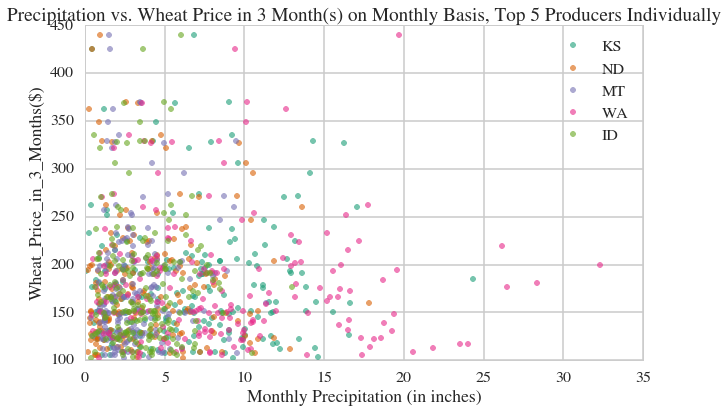

In [93]:
off_dftouse=offset(3, dftouse)
off_dftouse.head()

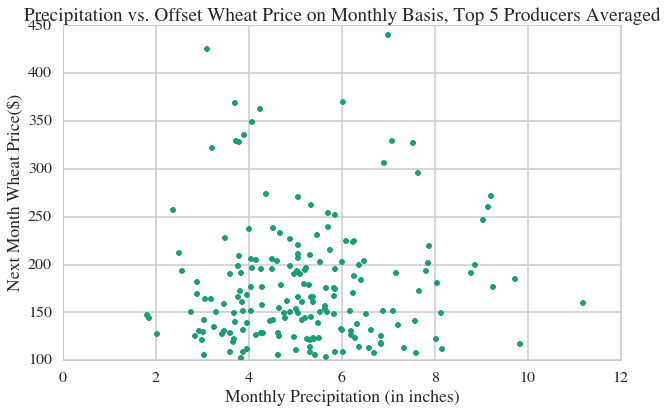

In [94]:
plt.plot(off_dftouse[["KS_P", "MT_P","ND_P","WA_P","ID_P"]].mean(axis=1),off_dftouse['Next_Price'],'.')
plt.ylabel('Next Month Wheat Price($)')
plt.xlabel('Monthly Precipitation (in inches)')
plt.title('Precipitation vs. Offset Wheat Price on Monthly Basis, Top 5 Producers Averaged')

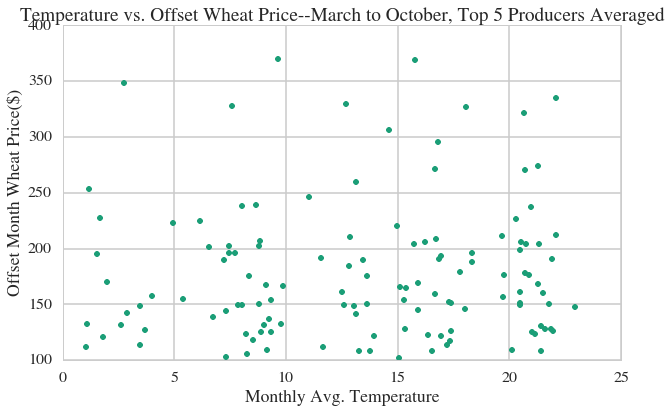

In [95]:
#Top 5 producers averaged, March through October 
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
dftouse_Mar_to_Oct = off_dftouse.loc[dftouse['Month'].isin(months)]
plt.plot(dftouse_Mar_to_Oct[["KS_T", "MT_T","ND_T","WA_T","ID_T"]].mean(axis=1),dftouse_Mar_to_Oct['Next_Price'],'.')
plt.ylabel('Offset Month Wheat Price($)')
plt.xlabel('Monthly Avg. Temperature')
plt.title('Temperature vs. Offset Wheat Price--March to October, Top 5 Producers Averaged')

From all that we have seen regarding temperature and precipitation, we have very poor correlation between precipitation & temperature vs. wheat price. Playing around with the offset did not improve the data much either. Since temperature and precipitation didn't work, we now look at the Palmer Drought Severity Index, which better quantifies drought conditions in the states. Since this is a better measure for growing conditions than just temperature and precipitation, we hope this shows us better correlation.

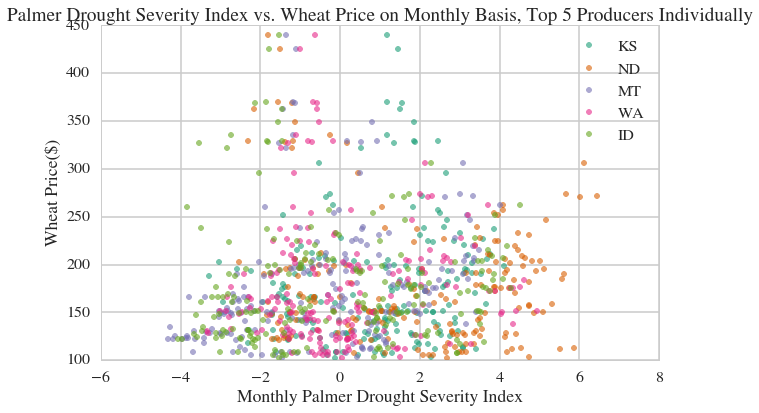

In [96]:
#Top 5 wheat producers, individually 
plt.ylabel('Wheat Price($)')
plt.xlabel('Monthly Palmer Drought Severity Index')
plt.plot(dftouse["KS_D"],dftouse['Wheat_Price'],'.', alpha=.6)
plt.plot(dftouse["ND_D"],dftouse['Wheat_Price'], '.', alpha=.6)
plt.plot(dftouse["MT_D"],dftouse['Wheat_Price'], '.', alpha=.6)
plt.plot(dftouse["WA_D"],dftouse['Wheat_Price'],'.', alpha=.6)
plt.plot(dftouse["ID_D"],dftouse['Wheat_Price'], '.', alpha=.6)
states = ['KS','ND','MT','WA','ID']
plt.legend(states)
plt.title('Palmer Drought Severity Index vs. Wheat Price on Monthly Basis, Top 5 Producers Individually')

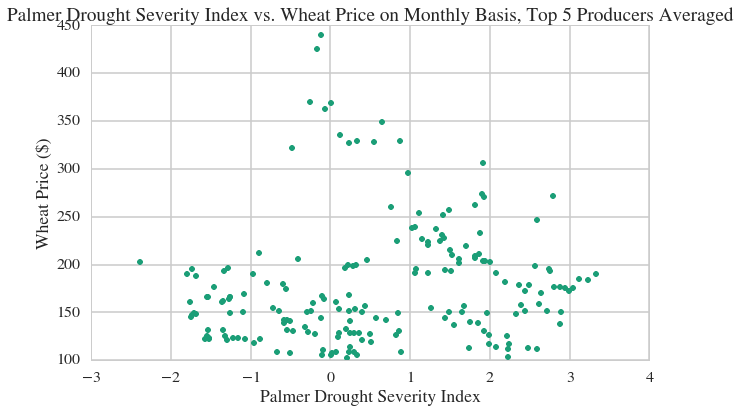

In [97]:
#Top 5 producers averaged
plt.plot(dftouse.ix[:,'1_D':'5_D'].mean(axis=1),dftouse[['Wheat_Price']].mean(axis=1),'.')
plt.xlabel('Palmer Drought Severity Index')
plt.ylabel('Wheat Price ($)')
plt.title('Palmer Drought Severity Index vs. Wheat Price on Monthly Basis, Top 5 Producers Averaged')

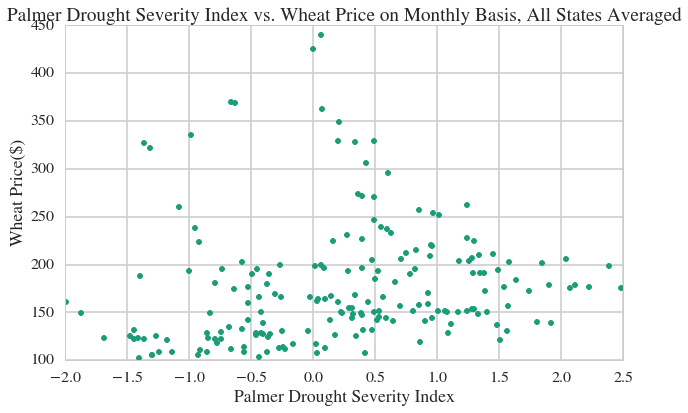

In [98]:
#All states 
plt.plot(dftouse.ix[:,'AL_D':'WY_D'].mean(axis=1),dftouse['Wheat_Price'],'.')
plt.ylabel('Wheat Price($)')
plt.xlabel('Palmer Drought Severity Index')
plt.title('Palmer Drought Severity Index vs. Wheat Price on Monthly Basis, All States Averaged')

The Palmer Drought Severity Index doesn't seem to do much better than temperature and precipitation. We also want to check if wheat prices were significantly higher than the norm in 2005, when there was a recorded and publicized drought. We also check the offset month again to see if there's any correlation.

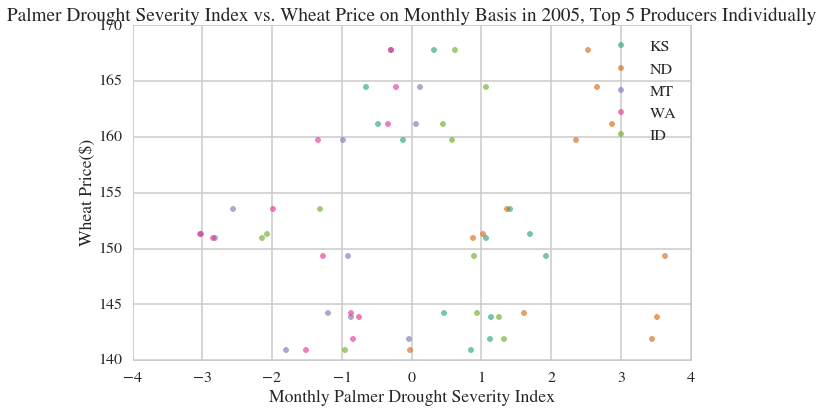

In [99]:
dftouse_2005=dftouse[dftouse['Year']==2005]
#Top 5 wheat producers, individually 
plt.ylabel('Wheat Price($)')
plt.xlabel('Monthly Palmer Drought Severity Index')
plt.plot(dftouse_2005["KS_D"],dftouse_2005['Wheat_Price'],'.', alpha=.6)
plt.plot(dftouse_2005["ND_D"],dftouse_2005['Wheat_Price'], '.', alpha=.6)
plt.plot(dftouse_2005["MT_D"],dftouse_2005['Wheat_Price'], '.', alpha=.6)
plt.plot(dftouse_2005["WA_D"],dftouse_2005['Wheat_Price'],'.', alpha=.6)
plt.plot(dftouse_2005["ID_D"],dftouse_2005['Wheat_Price'], '.', alpha=.6)
states = ['KS','ND','MT','WA','ID']
plt.legend(states)
plt.title('Palmer Drought Severity Index vs. Wheat Price on Monthly Basis in 2005, Top 5 Producers Individually')

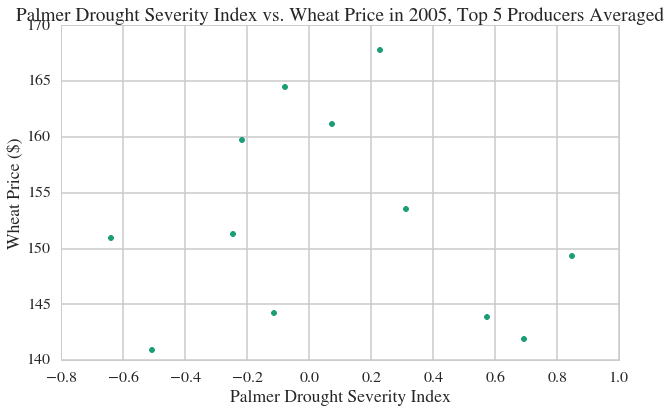

In [122]:
#Top 5 producers averaged
dftouse_2005=dftouse[dftouse['Year']==2005]
plt.plot(dftouse_2005.ix[:,'1_D':'5_D'].mean(axis=1),dftouse_2005[['Wheat_Price']].mean(axis=1),'.')
plt.xlabel('Palmer Drought Severity Index')
plt.ylabel('Wheat Price ($)')
plt.title('Palmer Drought Severity Index vs. Wheat Price in 2005, Top 5 Producers Averaged')

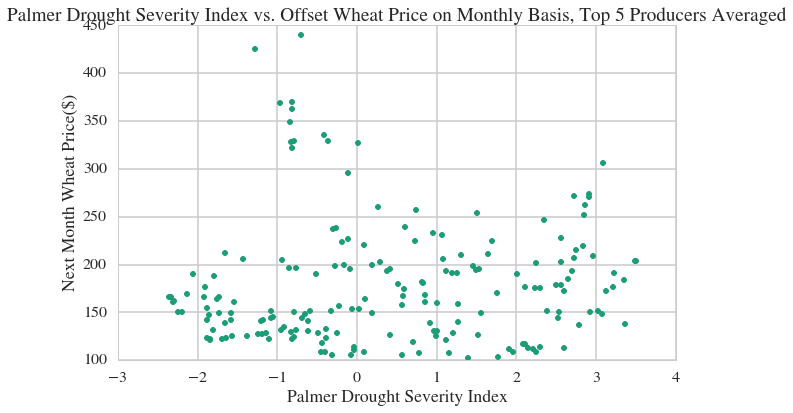

In [100]:
plt.plot(off_dftouse[["KS_D", "MT_D","ND_D","WA_D","ID_D"]].mean(axis=1),off_dftouse['Next_Price'],'.')
plt.ylabel('Next Month Wheat Price($)')
plt.xlabel('Palmer Drought Severity Index')
plt.title('Palmer Drought Severity Index vs. Offset Wheat Price on Monthly Basis, Top 5 Producers Averaged')

Just looking at this, you can see that there isn't too much correlation. In a publicized drought, the wheat prices were fairly average, and weren't even close to the $400 max price of wheat that you can see in other graphs. Therefore, PDSI doesn't have much influence on price either, apparently.

# 3. Linear Regression Model  of Wheat Price vs. various features


As a first pass naive prediction function, we will use a linear regression to model the relationship between a set of independent variables $X$ (which includes temperature, preciptation, previous price of wheat, and price of corn) and a dependent variable (our predicted price) $Y$.  This method assumes the relationship between each predictor $X$ is linearly related our price $Y$. We do not believe this is true, however, it is a starting point for exploring other models.  


$$ Y = \beta_0 + \beta_1 X $$

This is the simplest form of linear regression (one variable), we'll call this the simple model. 

* $\beta_0$ is the intercept of the linear model

* Multiple linear regression where we would input all four factors together will be in the form
    * $X_1$, $X_2$, $X_3$, $\ldots$

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p  $$

We can then estimate $\beta_0$ by using the least squares approximation method  by minimizing the difference between the following: 

$$ S = \sum_{i=1}^N r_i = \sum_{i=1}^N (y_i - (\beta_0 + \beta_1 x_i))^2 $$

where $N$ is the number of observations.  

First we plot the price of wheat in 2014, and attempt to model the price with a linear regression.

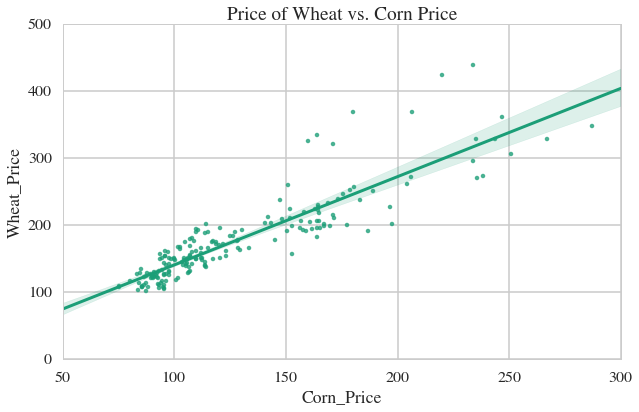

In [102]:
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Price of Wheat vs. Corn Price')
sns.regplot(y="Wheat_Price", x="Corn_Price", data=dftouse, fit_reg = True)

In [106]:
# Import regression modules
# ols - stands for Ordinary least squares, we'll use this
import statsmodels.api as sm
from statsmodels.formula.api import ols
m = ols('Wheat_Price ~ Corn_Price',dftouse).fit()
print m.summary()

                            OLS Regression Results                            
Dep. Variable:            Wheat_Price   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     722.9
Date:                Wed, 09 Dec 2015   Prob (F-statistic):           1.13e-66
Time:                        18:12:07   Log-Likelihood:                -917.88
No. Observations:                 192   AIC:                             1840.
Df Residuals:                     190   BIC:                             1846.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      9.1460      6.617      1.382      0.1

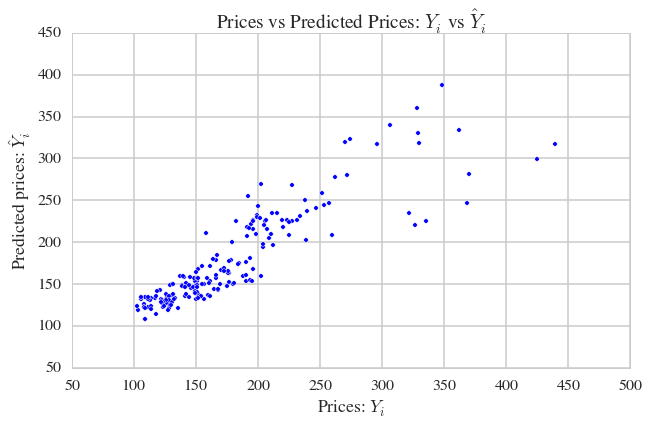

In [107]:
plt.scatter(dftouse['Wheat_Price'], m.fittedvalues)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted Prices: $Y_i$ vs $\hat{Y}_i$")

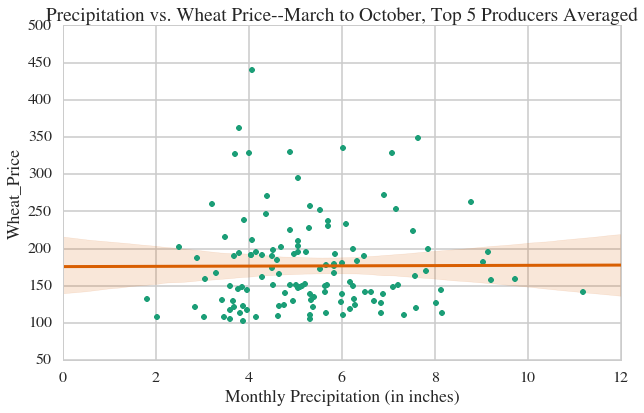

In [109]:
#Top 5 producers averaged, March through October 
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
big_df_Mar_to_Oct = dftouse.loc[dftouse['Month'].isin(months)]
plt.plot(big_df_Mar_to_Oct[["KS_P", "MT_P","ND_P","WA_P","ID_P"]].mean(axis=1),big_df_Mar_to_Oct['Wheat_Price'],'.')
plt.ylabel('Wheat Price($)')

plt.title('Precipitation vs. Wheat Price--March to October, Top 5 Producers Averaged')
sns.regplot(x=big_df_Mar_to_Oct[["KS_P", "MT_P","ND_P","WA_P","ID_P"]].mean(axis=1), y=big_df_Mar_to_Oct['Wheat_Price'], data=dftouse, fit_reg = True)
plt.xlabel('Monthly Precipitation (in inches)')

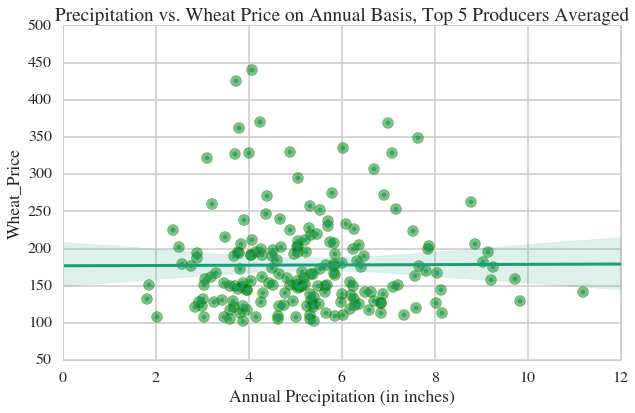

In [110]:
plt.scatter(dftouse[["KS_P", "MT_P","ND_P","WA_P","ID_P"]].mean(axis=1),dftouse['Wheat_Price'],s=120,alpha=.5,color='g')
plt.ylabel('Wheat Price($)')
plt.title('Precipitation vs. Wheat Price on Annual Basis, Top 5 Producers Averaged')
sns.regplot( x=dftouse[["KS_P", "MT_P","ND_P","WA_P","ID_P"]].mean(axis=1), y=dftouse['Wheat_Price'], data=dftouse, fit_reg = True)
plt.xlabel('Annual Precipitation (in inches)')

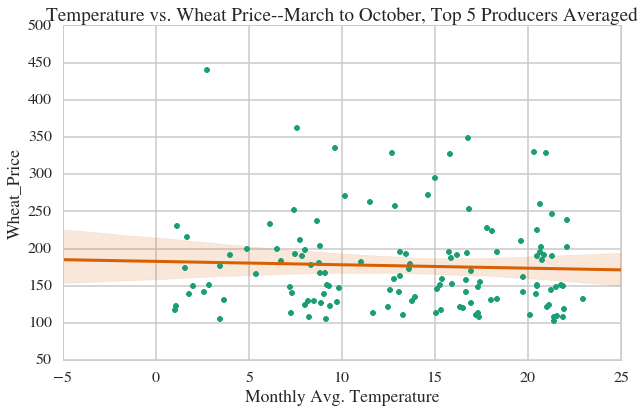

In [112]:
#Top 5 producers averaged, March through October  
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
bigdf_Mar_to_Oct = dftouse.loc[dftouse['Month'].isin(months)]
plt.plot(bigdf_Mar_to_Oct [["KS_T", "MT_T","ND_T","WA_T","ID_T"]].mean(axis=1),bigdf_Mar_to_Oct ['Wheat_Price'],'.')
plt.ylabel('Wheat Price($)')
plt.title('Temperature vs. Wheat Price--March to October, Top 5 Producers Averaged')
sns.regplot( x=bigdf_Mar_to_Oct [["KS_T", "MT_T","ND_T","WA_T","ID_T"]].mean(axis=1), y=bigdf_Mar_to_Oct ['Wheat_Price'], data=dftouse, fit_reg = True)
plt.xlabel('Monthly Avg. Temperature')

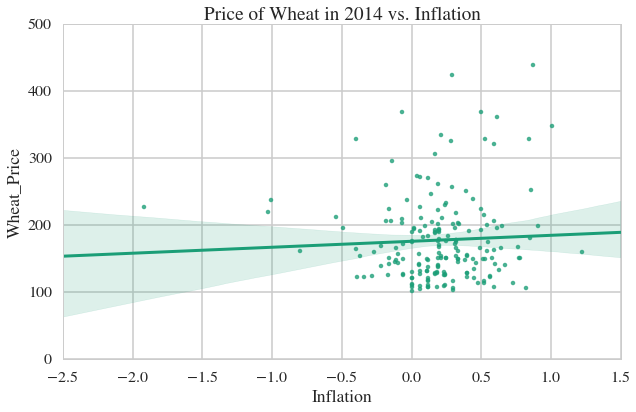

In [114]:
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Price of Wheat in 2014 vs. Inflation')
sns.regplot(y="Wheat_Price", x="Inflation", data=dftouse, fit_reg = True)

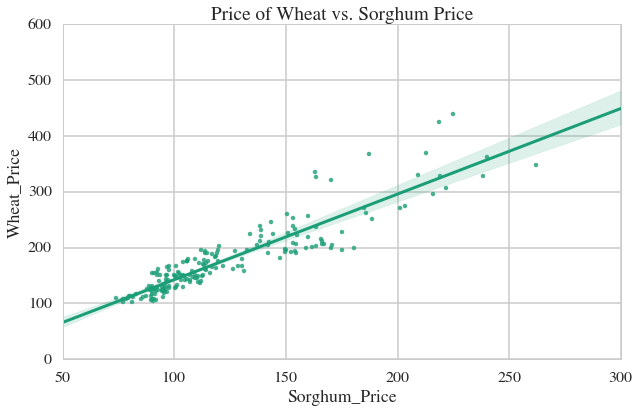

In [115]:
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Price of Wheat vs. Sorghum Price')
sns.regplot(y="Wheat_Price", x="Sorghum_Price", data=dftouse, fit_reg = True)

In [116]:
# Import regression modules
# ols - stands for Ordinary least squares, we'll use this
import statsmodels.api as sm
from statsmodels.formula.api import ols
m = ols('Wheat_Price ~ Sorghum_Price',dftouse).fit()
print m.summary()

                            OLS Regression Results                            
Dep. Variable:            Wheat_Price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     940.3
Date:                Wed, 09 Dec 2015   Prob (F-statistic):           1.69e-75
Time:                        18:19:33   Log-Likelihood:                -897.37
No. Observations:                 192   AIC:                             1799.
Df Residuals:                     190   BIC:                             1805.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       -10.7097      6.432     -1.665

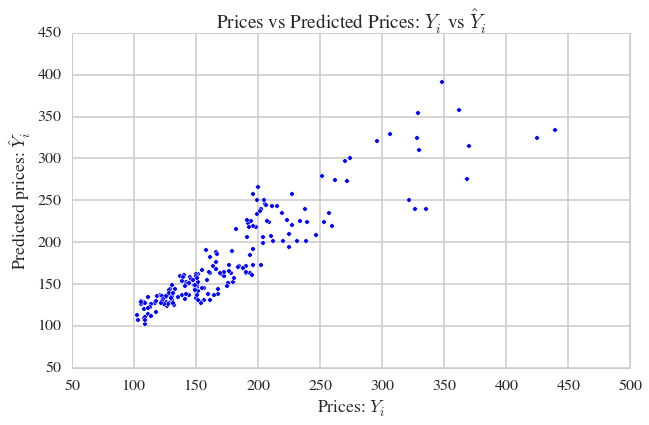

In [117]:
plt.scatter(dftouse['Wheat_Price'], m.fittedvalues)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted Prices: $Y_i$ vs $\hat{Y}_i$")

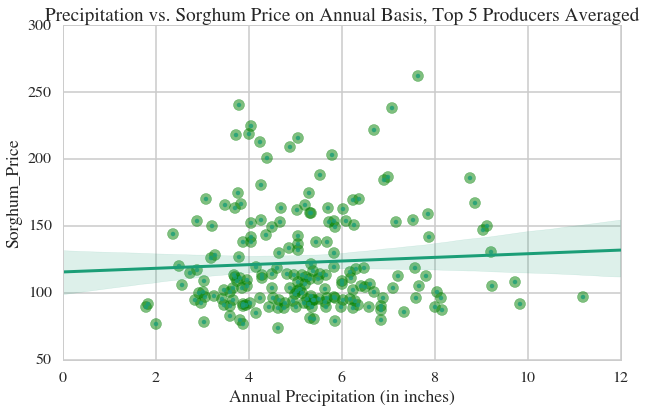

In [118]:
plt.scatter(dftouse[["KS_P", "MT_P","ND_P","WA_P","ID_P"]].mean(axis=1),dftouse['Sorghum_Price'],s=120,alpha=.5,color='g')
plt.ylabel('Wheat Price($)')
plt.title('Precipitation vs. Sorghum Price on Annual Basis, Top 5 Producers Averaged')
sns.regplot( x=dftouse[["KS_P", "MT_P","ND_P","WA_P","ID_P"]].mean(axis=1), y=dftouse['Sorghum_Price'], data=dftouse, fit_reg = True)
plt.xlabel('Annual Precipitation (in inches)')

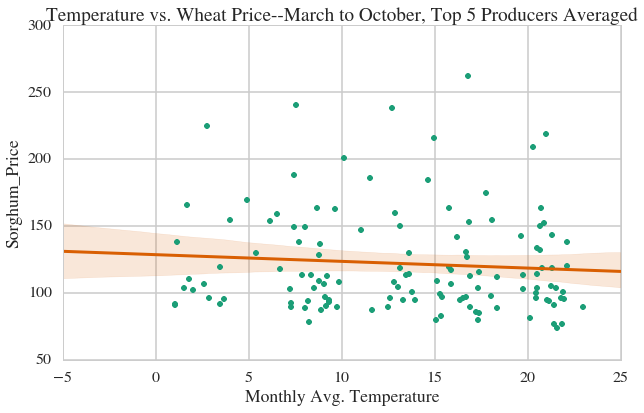

In [120]:

months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
bigdf_Mar_to_Oct = dftouse.loc[dftouse['Month'].isin(months)]
plt.plot(bigdf_Mar_to_Oct [["KS_T", "MT_T","ND_T","WA_T","ID_T"]].mean(axis=1),bigdf_Mar_to_Oct ['Sorghum_Price'],'.')
plt.ylabel('Sorghum Price($)')
plt.title('Temperature vs. Wheat Price--March to October, Top 5 Producers Averaged')
sns.regplot( x=bigdf_Mar_to_Oct [["KS_T", "MT_T","ND_T","WA_T","ID_T"]].mean(axis=1), y=bigdf_Mar_to_Oct ['Sorghum_Price'], data=dftouse, fit_reg = True)
plt.xlabel('Monthly Avg. Temperature')

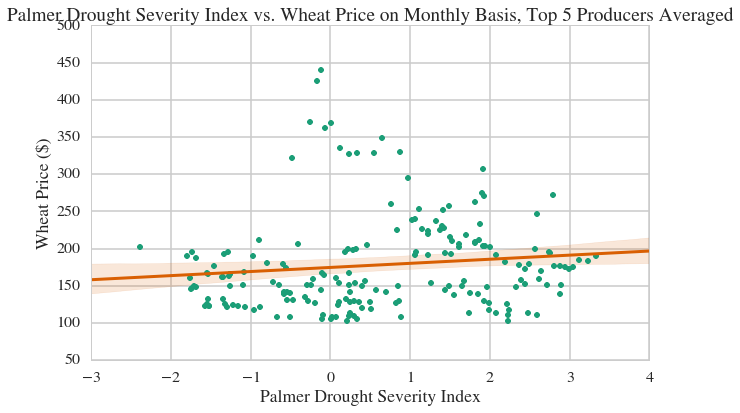

In [128]:
#Top 5 producers averaged
plt.plot(dftouse.ix[:,'1_D':'5_D'].mean(axis=1),dftouse[['Wheat_Price']].mean(axis=1),'.')
plt.title('Palmer Drought Severity Index vs. Wheat Price on Monthly Basis, Top 5 Producers Averaged')
sns.regplot(y=dftouse[['Wheat_Price']].mean(axis=1), x=dftouse.ix[:,'1_D':'5_D'].mean(axis=1), data=dftouse, fit_reg = True)
plt.xlabel('Palmer Drought Severity Index')
plt.ylabel('Wheat Price ($)')